# Desafio Kaggle: Titanic

- https://www.kaggle.com/c/titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

---

### Importando os arquivos

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

---

### Visualizando os arquivos importados

In [4]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [7]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
# Salvar PassengerId para auxiliar na criação do arquivo que será enviado ao Kaggle
passengerId = test['PassengerId']

# Criando um DF novo com o train e o test
titanic_df = train.append(test, ignore_index=True)

In [9]:
# Para auxiliar no momento separar o DF titanic_df em train e test
train_index = len(train)
test_index = len(titanic_df) - len(test)

In [10]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [11]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [12]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
# Criando o df onde iremos processar os modelos de ML

df = pd.DataFrame()

### Survived

In [15]:
titanic_df['Survived'].nunique()

2

In [16]:
titanic_df['Survived'].unique()

array([ 0.,  1., nan])

In [17]:
titanic_df['Survived'].isnull().sum()

418

In [18]:
titanic_df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

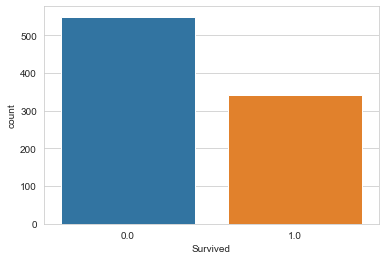

In [19]:
sns.countplot(data = titanic_df, x = 'Survived')

Quantidade de valores únicos: 2

Quais são os valores únicos: [ 0.  1. nan]

Quantidade de valores nulos: 418

Quantidade por opção: 
0.0    549
1.0    342
Name: Survived, dtype: int64


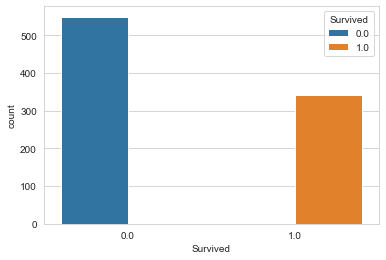

In [20]:
# Criando uma função para ajudar no momento de visualizar as informações de cada coluna

def titanic_func(data, column, count = True):
    print(f'Quantidade de valores únicos: {data[column].nunique()}')
    print(f'\nQuais são os valores únicos: {data[column].unique()}')
    print(f'\nQuantidade de valores nulos: {data[column].isnull().sum()}')
    print(f'\nQuantidade por opção: \n{data[column].value_counts()}')
    
    if count == True:
        sns.countplot(data = data, x = column, hue = 'Survived')
    else:
        sns.displot(data[column], kde = True)
    
    
titanic_func(titanic_df, 'Survived')

In [21]:
df['Survived'] = titanic_df['Survived']

In [22]:
df

,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
1304,NaN
1305,NaN
1306,NaN
1307,NaN


### Pclass

Quantidade de valores únicos: 3

Quais são os valores únicos: [3 1 2]

Quantidade de valores nulos: 0

Quantidade por opção: 
3    709
1    323
2    277
Name: Pclass, dtype: int64


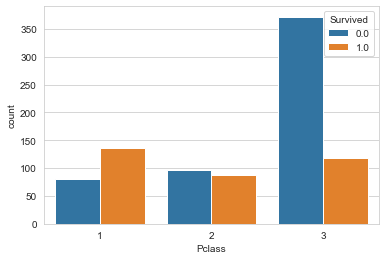

In [23]:
titanic_func(titanic_df, 'Pclass')

In [24]:
df['Pclass'] = titanic_df['Pclass']
df.head()

,Survived,Pclass
0,0.0,3
1,1.0,1
2,1.0,3
3,1.0,1
4,0.0,3


### Sex

In [25]:
titanic_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [26]:
# titanic_df['Sex'].map({'female': 1, 'male': 0})
titanic_df['Sex'] = titanic_df['Sex'].replace(['female', 'male'], [1, 0])

Quantidade de valores únicos: 2

Quais são os valores únicos: [0 1]

Quantidade de valores nulos: 0

Quantidade por opção: 
0    843
1    466
Name: Sex, dtype: int64


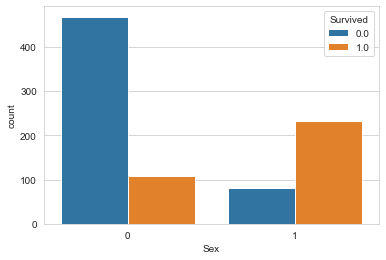

In [27]:
titanic_func(titanic_df, 'Sex')

In [28]:
df['Sex'] = titanic_df['Sex']
df.head()

,Survived,Pclass,Sex
0,0.0,3,0
1,1.0,1,1
2,1.0,3,1
3,1.0,1,1
4,0.0,3,0


### Age

Quantidade de valores únicos: 98

Quais são os valores únicos: [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.   22.5  18.5  67.   76.   26.5  60.5  11.5
  0.33  0.17 38.5 ]

Quantidade de valores nulos: 263

Quantidade por opção: 
24.00    47
22.00    43
21.00    41
30.00    40
18.00    39
         ..
20.50     1
11.50     1
22.50     1
0.33      1
60.50     1
Name: Age, Length: 98, dtype: int64


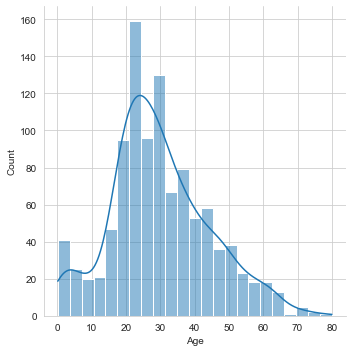

In [29]:
titanic_func(titanic_df, 'Age', False)

In [30]:
titanic_df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,-0.013406,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.124617,-0.408106,0.060832,0.018322,-0.558629
Sex,-0.013406,0.543351,-0.124617,1.000000,-0.063645,0.109609,0.213125,0.185523
Age,0.028814,-0.077221,-0.408106,-0.063645,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,0.109609,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,0.213125,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.185523,0.178740,0.160238,0.221539,1.000000


In [31]:
titanic_df[titanic_df['Pclass'] == 1]['Age'].mean()

39.15992957746479

In [32]:
titanic_df[titanic_df['Pclass'] == 2]['Age'].mean()

29.506704980842912

In [33]:
titanic_df[titanic_df['Pclass'] == 3]['Age'].mean()

24.81636726546906

In [34]:
for i in sorted(titanic_df['Pclass'].unique()):
    print(f"Pessoas da {i}ª classe tem a média de idade de: {titanic_df[titanic_df['Pclass'] == i]['Age'].mean():.0f} anos.")

Pessoas da 1ª classe tem a média de idade de: 39 anos.
Pessoas da 2ª classe tem a média de idade de: 30 anos.
Pessoas da 3ª classe tem a média de idade de: 25 anos.


In [35]:
titanic_df[titanic_df['Pclass'] == 1]['Age'].isnull().sum()

39

In [36]:
titanic_df['Age'].isnull().sum()

263

In [37]:
count = 0
for i in titanic_df.index:
    
    if pd.isnull(titanic_df['Age'][i]):
        
        if titanic_df['Pclass'][i] == 1:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 1]['Age'].mean(), 0)
            
        elif titanic_df['Pclass'][i] == 2:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean(), 0)
            
        elif titanic_df['Pclass'][i] == 3:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
            
    else:
        continue

<ipython-input-37-ccff2981a33c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
<ipython-input-37-ccff2981a33c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean(), 0)
<ipython-input-37-ccff2981a33c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = 

<ipython-input-37-ccff2981a33c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
<ipython-input-37-ccff2981a33c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
<ipython-input-37-ccff2981a33c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = 

<ipython-input-37-ccff2981a33c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
<ipython-input-37-ccff2981a33c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
<ipython-input-37-ccff2981a33c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = 

In [38]:
titanic_df[titanic_df['Pclass'] == 1]['Age'].isnull().sum()

0

In [39]:
titanic_df['Age'].isnull().sum()

0

In [40]:
titanic_df['Age']

0       22.0
1       38.0
2       26.0
3       35.0
4       35.0
        ... 
1304    25.0
1305    39.0
1306    38.5
1307    25.0
1308    25.0
Name: Age, Length: 1309, dtype: float64

In [41]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 122.8+ KB


In [42]:
df['Age'] = titanic_df['Age']
df.head()

,Survived,Pclass,Sex,Age
0,0.0,3,0,22.0
1,1.0,1,1,38.0
2,1.0,3,1,26.0
3,1.0,1,1,35.0
4,0.0,3,0,35.0


### SibSp

Quantidade de valores únicos: 7

Quais são os valores únicos: [1 0 3 4 2 5 8]

Quantidade de valores nulos: 0

Quantidade por opção: 
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64


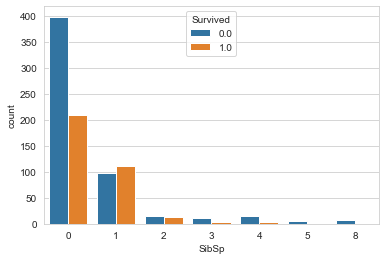

In [43]:
titanic_func(titanic_df, 'SibSp')

In [44]:
df['SibSp'] = titanic_df['SibSp']
df.head()

,Survived,Pclass,Sex,Age,SibSp
0,0.0,3,0,22.0,1
1,1.0,1,1,38.0,1
2,1.0,3,1,26.0,0
3,1.0,1,1,35.0,1
4,0.0,3,0,35.0,0


### Parch

Quantidade de valores únicos: 8

Quais são os valores únicos: [0 1 2 5 3 4 6 9]

Quantidade de valores nulos: 0

Quantidade por opção: 
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: Parch, dtype: int64


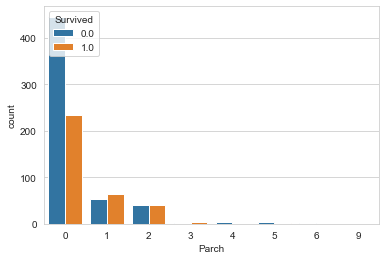

In [45]:
titanic_func(titanic_df, 'Parch')

In [46]:
df['Parch'] = titanic_df['Parch']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0.0,3,0,22.0,1,0
1,1.0,1,1,38.0,1,0
2,1.0,3,1,26.0,0,0
3,1.0,1,1,35.0,1,0
4,0.0,3,0,35.0,0,0


### Criando coluna - FamilySize 

In [47]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1 

In [48]:
df['FamilySize'] = titanic_df['FamilySize']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize
0,0.0,3,0,22.0,1,0,2
1,1.0,1,1,38.0,1,0,2
2,1.0,3,1,26.0,0,0,1
3,1.0,1,1,35.0,1,0,2
4,0.0,3,0,35.0,0,0,1


### Fare

Quantidade de valores únicos: 281

Quais são os valores únicos: [  7.25    71.2833   7.925   53.1      8.05     8.4583  51.8625  21.075
  11.1333  30.0708  16.7     26.55    31.275    7.8542  16.      29.125
  13.      18.       7.225   26.       8.0292  35.5     31.3875 263.
   7.8792   7.8958  27.7208 146.5208   7.75    10.5     82.1708  52.
   7.2292  11.2417   9.475   21.      41.5792  15.5     21.6792  17.8
  39.6875   7.8     76.7292  61.9792  27.75    46.9     80.      83.475
  27.9     15.2458   8.1583   8.6625  73.5     14.4542  56.4958   7.65
  29.      12.475    9.       9.5      7.7875  47.1     15.85    34.375
  61.175   20.575   34.6542  63.3583  23.      77.2875   8.6542   7.775
  24.15     9.825   14.4583 247.5208   7.1417  22.3583   6.975    7.05
  14.5     15.0458  26.2833   9.2167  79.2      6.75    11.5     36.75
   7.7958  12.525   66.6      7.3125  61.3792   7.7333  69.55    16.1
  15.75    20.525   55.      25.925   33.5     30.6958  25.4667  28.7125
   0.      1

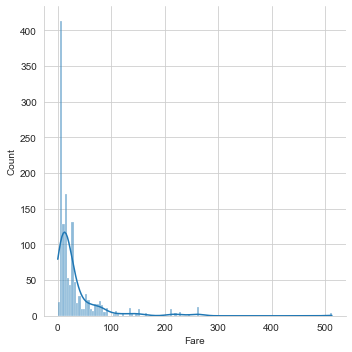

In [49]:
titanic_func(titanic_df, 'Fare', False)

In [50]:
titanic_df[titanic_df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,1


In [51]:
titanic_df[titanic_df['Pclass'] == 3]['Fare'].mean()

13.302888700564969

In [52]:
titanic_df['Fare'].fillna(titanic_df[titanic_df['Pclass'] == 3]['Fare'].mean(), inplace = True)

In [53]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
FamilySize        0
dtype: int64

In [54]:
df['Fare'] = titanic_df['Fare']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare
0,0.0,3,0,22.0,1,0,2,7.2500
1,1.0,1,1,38.0,1,0,2,71.2833
2,1.0,3,1,26.0,0,0,1,7.9250
3,1.0,1,1,35.0,1,0,2,53.1000
4,0.0,3,0,35.0,0,0,1,8.0500


### Cabin

In [55]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2


In [56]:
titanic_df['Cabin'].isnull().sum()

1014

In [57]:
titanic_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

### Embarked

Quantidade de valores únicos: 3

Quais são os valores únicos: ['S' 'C' 'Q' nan]

Quantidade de valores nulos: 2

Quantidade por opção: 
S    914
C    270
Q    123
Name: Embarked, dtype: int64


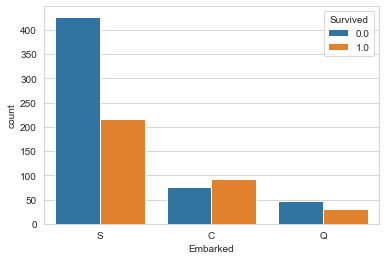

In [58]:
titanic_func(titanic_df, 'Embarked')

In [59]:
titanic_df[titanic_df['Embarked'] == "S"]['Survived'].mean()

0.33695652173913043

In [60]:
titanic_df[titanic_df['Embarked'] == "S"]['Pclass'].mean()

2.3479212253829322

In [61]:
titanic_df[titanic_df['Embarked'] == "C"]['Survived'].mean()

0.5535714285714286

In [62]:
titanic_df[titanic_df['Embarked'] == "C"]['Pclass'].mean()

1.8518518518518519

In [63]:
titanic_df[titanic_df['Embarked'] == "Q"]['Survived'].mean()

0.38961038961038963

In [64]:
titanic_df[titanic_df['Embarked'] == "Q"]['Pclass'].mean()

2.894308943089431

In [65]:
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
61,62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,1


In [66]:
titanic_df['Embarked'].fillna('C', inplace = True)

In [67]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
dtype: int64

In [68]:
df['Embarked'] = titanic_df['Embarked']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked
0,0.0,3,0,22.0,1,0,2,7.2500,S
1,1.0,1,1,38.0,1,0,2,71.2833,C
2,1.0,3,1,26.0,0,0,1,7.9250,S
3,1.0,1,1,35.0,1,0,2,53.1000,S
4,0.0,3,0,35.0,0,0,1,8.0500,S


### Name

In [69]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1


In [70]:
titanic_df['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [71]:
# [titanic_df['Name'][n].split(',')[1].split('.')[0].strip() for n in titanic_df.index]
titanic_df['Title'] = titanic_df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [72]:
titanic_df['Title'].nunique()

18

In [73]:
titanic_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [74]:
titanic_df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Lady              1
Capt              1
Don               1
the Countess      1
Dona              1
Jonkheer          1
Mme               1
Sir               1
Name: Title, dtype: int64

In [75]:
titanic_df['Title'] = [n if n in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Person' for n in titanic_df['Title']]

In [76]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,25.0,0,0,A.5. 3236,8.0500,NaN,S,1,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C,1,Person
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",0,25.0,0,0,359309,8.0500,NaN,S,1,Mr


In [77]:
df['Title'] = titanic_df['Title']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked,Title
0,0.0,3,0,22.0,1,0,2,7.2500,S,Mr
1,1.0,1,1,38.0,1,0,2,71.2833,C,Mrs
2,1.0,3,1,26.0,0,0,1,7.9250,S,Miss
3,1.0,1,1,35.0,1,0,2,53.1000,S,Mrs
4,0.0,3,0,35.0,0,0,1,8.0500,S,Mr


Quantidade de valores únicos: 5

Quais são os valores únicos: ['Mr' 'Mrs' 'Miss' 'Master' 'Person']

Quantidade de valores nulos: 0

Quantidade por opção: 
Mr        757
Miss      260
Mrs       197
Master     61
Person     34
Name: Title, dtype: int64


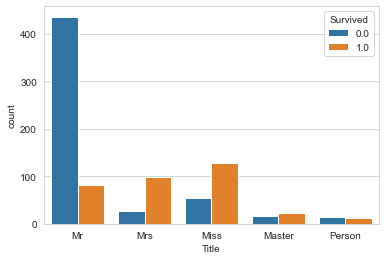

In [78]:
titanic_func(titanic_df, 'Title')

In [79]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
Title             0
dtype: int64

---

In [80]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked,Title
0,0.0,3,0,22.0,1,0,2,7.2500,S,Mr
1,1.0,1,1,38.0,1,0,2,71.2833,C,Mrs
2,1.0,3,1,26.0,0,0,1,7.9250,S,Miss
3,1.0,1,1,35.0,1,0,2,53.1000,S,Mrs
4,0.0,3,0,35.0,0,0,1,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,0,25.0,0,0,1,8.0500,S,Mr
1305,NaN,1,1,39.0,0,0,1,108.9000,C,Person
1306,NaN,3,0,38.5,0,0,1,7.2500,S,Mr
1307,NaN,3,0,25.0,0,0,1,8.0500,S,Mr


In [81]:
pclass = pd.get_dummies(df['Pclass'], prefix = "Pclass", drop_first = True)
title = pd.get_dummies(df['Title'], prefix = 'Title', drop_first = True)
embarked = pd.get_dummies(df['Embarked'], prefix = 'Embarked', drop_first = True)

In [82]:
titanic_completo = pd.concat([df, pclass, title, embarked], axis = 1)

In [83]:
titanic_completo.drop(['Pclass', 'Title', 'Embarked'], axis=1, inplace=True)

In [84]:
titanic_completo

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1.0,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1.0,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1.0,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0.0,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,NaN,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,NaN,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


In [85]:
train = titanic_completo[:train_index].copy()
test = titanic_completo[test_index:].copy()

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Sex           891 non-null    int64  
 2   Age           891 non-null    float64
 3   SibSp         891 non-null    int64  
 4   Parch         891 non-null    int64  
 5   FamilySize    891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Pclass_2      891 non-null    uint8  
 8   Pclass_3      891 non-null    uint8  
 9   Title_Miss    891 non-null    uint8  
 10  Title_Mr      891 non-null    uint8  
 11  Title_Mrs     891 non-null    uint8  
 12  Title_Person  891 non-null    uint8  
 13  Embarked_Q    891 non-null    uint8  
 14  Embarked_S    891 non-null    uint8  
dtypes: float64(3), int64(4), uint8(8)
memory usage: 55.8 KB


In [87]:
train['Survived'] = train['Survived'].astype(int)

In [111]:
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [112]:
X_test = test.drop('Survived', axis = 1).values

KeyError: "['Survived'] not found in axis"

---

In [113]:
# Função que processa o Algoritmo e retorna a acurácia

def fit_ml_algo(algo, X_train, y_train, cv):
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    train_pred = model_selection.cross_val_predict(algo, X_train, y_train, cv = cv, n_jobs = -1)
    
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Random Forest

In [114]:
train_pred_rf, acc_rf, acc_cv_rf = fit_ml_algo(RandomForestClassifier(), X, y, 10)

print(f"Accuracy: {acc_rf}")
print(f"Accuracy CV 10-Fold: {acc_cv_rf}")

Accuracy: 98.32
Accuracy CV 10-Fold: 80.81


### Logistic regression

In [115]:
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(max_iter=1000), X, y, 10)

print(f"Accuracy: {acc_log}")
print(f"Accuracy CV 10-Fold: {acc_cv_log}")

Accuracy: 82.94
Accuracy CV 10-Fold: 82.49


### K-Nearest Neighbours

In [116]:
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), X, y, 10)

print(f"Accuracy: {acc_knn}")
print(f"Accuracy CV 10-Fold: {acc_cv_knn}")

Accuracy: 80.92
Accuracy CV 10-Fold: 72.5


### Gaussian Naive Bayes

In [117]:
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), X, y, 10)

print(f"Accuracy: {acc_gaussian}")
print(f"Accuracy CV 10-Fold: {acc_cv_gaussian}")

Accuracy: 78.79
Accuracy CV 10-Fold: 78.56


### Linear Support Vector Machines (SVC)

In [118]:
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(dual=False), X, y, 10)

print(f"Accuracy: {acc_linear_svc}")
print(f"Accuracy CV 10-Fold: {acc_cv_linear_svc}")

Accuracy: 83.28
Accuracy CV 10-Fold: 82.72


### Stochastic Gradient Descent

In [119]:
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), X, y, 10)

print(f"Accuracy: {acc_sgd}")
print(f"Accuracy CV 10-Fold: {acc_cv_sgd}")

Accuracy: 61.84
Accuracy CV 10-Fold: 73.06


### Decision Tree Classifier

In [120]:
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), X, y, 10)

print(f"Accuracy: {acc_dt}")
print(f"Accuracy CV 10-Fold: {acc_cv_dt}")

Accuracy: 98.32
Accuracy CV 10-Fold: 79.01


### Gradient Boost Trees

In [121]:
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), X, y, 10)

print(f"Accuracy: {acc_gbt}")
print(f"Accuracy CV 10-Fold: {acc_cv_gbt}")

Accuracy: 89.67
Accuracy CV 10-Fold: 83.16


### CatBoost

In [122]:
X

,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,1,13.0000,1,0,0,0,0,1,0,1
887,1,19.0,0,0,1,30.0000,0,0,1,0,0,0,0,1
888,1,25.0,1,2,4,23.4500,0,1,1,0,0,0,0,1
889,0,26.0,0,0,1,30.0000,0,0,0,1,0,0,0,0


In [123]:
cat_features = np.where(X.dtypes != float)[0]
cat_features

array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64)

In [124]:
train_pool = Pool(X, y, cat_features)

In [125]:
catboost_model = CatBoostClassifier(iterations = 1000, custom_loss = ['Accuracy'], loss_function = 'Logloss')

catboost_model.fit(train_pool, plot = True)

acc_catboost = round(catboost_model.score(X, y) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009807
0:	learn: 0.6861124	total: 18.8ms	remaining: 18.8s
1:	learn: 0.6797657	total: 41.1ms	remaining: 20.5s
2:	learn: 0.6737111	total: 69ms	remaining: 22.9s
3:	learn: 0.6691034	total: 93.1ms	remaining: 23.2s
4:	learn: 0.6636707	total: 114ms	remaining: 22.7s
5:	learn: 0.6586145	total: 136ms	remaining: 22.6s
6:	learn: 0.6540375	total: 160ms	remaining: 22.7s
7:	learn: 0.6492574	total: 182ms	remaining: 22.5s
8:	learn: 0.6442929	total: 206ms	remaining: 22.6s
9:	learn: 0.6404454	total: 228ms	remaining: 22.6s
10:	learn: 0.6356660	total: 253ms	remaining: 22.8s
11:	learn: 0.6312043	total: 277ms	remaining: 22.8s
12:	learn: 0.6260579	total: 299ms	remaining: 22.7s
13:	learn: 0.6214943	total: 321ms	remaining: 22.6s
14:	learn: 0.6164364	total: 340ms	remaining: 22.3s
15:	learn: 0.6134351	total: 356ms	remaining: 21.9s
16:	learn: 0.6084737	total: 377ms	remaining: 21.8s
17:	learn: 0.6043643	total: 399ms	remaining: 21.8s
18:	learn: 0.5999446	total: 420ms	remaining: 21.7s
19:	learn

169:	learn: 0.3989325	total: 3.32s	remaining: 16.2s
170:	learn: 0.3985743	total: 3.35s	remaining: 16.2s
171:	learn: 0.3982932	total: 3.37s	remaining: 16.2s
172:	learn: 0.3981058	total: 3.4s	remaining: 16.2s
173:	learn: 0.3977384	total: 3.42s	remaining: 16.2s
174:	learn: 0.3975536	total: 3.43s	remaining: 16.2s
175:	learn: 0.3971076	total: 3.45s	remaining: 16.2s
176:	learn: 0.3969555	total: 3.47s	remaining: 16.1s
177:	learn: 0.3965984	total: 3.49s	remaining: 16.1s
178:	learn: 0.3964886	total: 3.51s	remaining: 16.1s
179:	learn: 0.3960620	total: 3.53s	remaining: 16.1s
180:	learn: 0.3955671	total: 3.55s	remaining: 16.1s
181:	learn: 0.3953445	total: 3.57s	remaining: 16s
182:	learn: 0.3951399	total: 3.58s	remaining: 16s
183:	learn: 0.3947459	total: 3.6s	remaining: 16s
184:	learn: 0.3947323	total: 3.61s	remaining: 15.9s
185:	learn: 0.3944110	total: 3.63s	remaining: 15.9s
186:	learn: 0.3940785	total: 3.65s	remaining: 15.9s
187:	learn: 0.3937097	total: 3.67s	remaining: 15.8s
188:	learn: 0.393586

328:	learn: 0.3638560	total: 6.31s	remaining: 12.9s
329:	learn: 0.3636776	total: 6.33s	remaining: 12.8s
330:	learn: 0.3633446	total: 6.34s	remaining: 12.8s
331:	learn: 0.3631500	total: 6.36s	remaining: 12.8s
332:	learn: 0.3630972	total: 6.38s	remaining: 12.8s
333:	learn: 0.3630626	total: 6.39s	remaining: 12.7s
334:	learn: 0.3630620	total: 6.39s	remaining: 12.7s
335:	learn: 0.3628846	total: 6.42s	remaining: 12.7s
336:	learn: 0.3627627	total: 6.43s	remaining: 12.7s
337:	learn: 0.3624595	total: 6.45s	remaining: 12.6s
338:	learn: 0.3623725	total: 6.47s	remaining: 12.6s
339:	learn: 0.3623378	total: 6.49s	remaining: 12.6s
340:	learn: 0.3622689	total: 6.51s	remaining: 12.6s
341:	learn: 0.3620451	total: 6.53s	remaining: 12.6s
342:	learn: 0.3620173	total: 6.54s	remaining: 12.5s
343:	learn: 0.3620061	total: 6.55s	remaining: 12.5s
344:	learn: 0.3617637	total: 6.57s	remaining: 12.5s
345:	learn: 0.3617037	total: 6.59s	remaining: 12.5s
346:	learn: 0.3617032	total: 6.6s	remaining: 12.4s
347:	learn: 0

491:	learn: 0.3466639	total: 9.23s	remaining: 9.53s
492:	learn: 0.3466142	total: 9.26s	remaining: 9.52s
493:	learn: 0.3465910	total: 9.29s	remaining: 9.51s
494:	learn: 0.3465424	total: 9.3s	remaining: 9.49s
495:	learn: 0.3464345	total: 9.32s	remaining: 9.47s
496:	learn: 0.3462963	total: 9.34s	remaining: 9.46s
497:	learn: 0.3462644	total: 9.36s	remaining: 9.44s
498:	learn: 0.3461920	total: 9.38s	remaining: 9.42s
499:	learn: 0.3461478	total: 9.4s	remaining: 9.4s
500:	learn: 0.3461218	total: 9.42s	remaining: 9.38s
501:	learn: 0.3459383	total: 9.44s	remaining: 9.36s
502:	learn: 0.3459043	total: 9.46s	remaining: 9.34s
503:	learn: 0.3458446	total: 9.47s	remaining: 9.32s
504:	learn: 0.3458020	total: 9.49s	remaining: 9.3s
505:	learn: 0.3457540	total: 9.51s	remaining: 9.29s
506:	learn: 0.3457282	total: 9.53s	remaining: 9.27s
507:	learn: 0.3455989	total: 9.55s	remaining: 9.25s
508:	learn: 0.3455147	total: 9.57s	remaining: 9.23s
509:	learn: 0.3454742	total: 9.59s	remaining: 9.21s
510:	learn: 0.34

652:	learn: 0.3320931	total: 12.2s	remaining: 6.46s
653:	learn: 0.3320691	total: 12.2s	remaining: 6.44s
654:	learn: 0.3319891	total: 12.2s	remaining: 6.42s
655:	learn: 0.3318754	total: 12.2s	remaining: 6.41s
656:	learn: 0.3318672	total: 12.2s	remaining: 6.38s
657:	learn: 0.3318558	total: 12.2s	remaining: 6.36s
658:	learn: 0.3317210	total: 12.2s	remaining: 6.34s
659:	learn: 0.3316661	total: 12.3s	remaining: 6.32s
660:	learn: 0.3316548	total: 12.3s	remaining: 6.29s
661:	learn: 0.3315347	total: 12.3s	remaining: 6.28s
662:	learn: 0.3312045	total: 12.3s	remaining: 6.26s
663:	learn: 0.3311674	total: 12.3s	remaining: 6.24s
664:	learn: 0.3309912	total: 12.3s	remaining: 6.22s
665:	learn: 0.3309659	total: 12.4s	remaining: 6.21s
666:	learn: 0.3309647	total: 12.4s	remaining: 6.19s
667:	learn: 0.3309271	total: 12.4s	remaining: 6.17s
668:	learn: 0.3308534	total: 12.4s	remaining: 6.15s
669:	learn: 0.3307348	total: 12.5s	remaining: 6.14s
670:	learn: 0.3306826	total: 12.5s	remaining: 6.12s
671:	learn: 

814:	learn: 0.3181786	total: 15.1s	remaining: 3.44s
815:	learn: 0.3179641	total: 15.2s	remaining: 3.42s
816:	learn: 0.3177246	total: 15.2s	remaining: 3.4s
817:	learn: 0.3176159	total: 15.2s	remaining: 3.39s
818:	learn: 0.3176105	total: 15.2s	remaining: 3.37s
819:	learn: 0.3175924	total: 15.3s	remaining: 3.35s
820:	learn: 0.3173574	total: 15.3s	remaining: 3.33s
821:	learn: 0.3170732	total: 15.3s	remaining: 3.32s
822:	learn: 0.3169338	total: 15.3s	remaining: 3.3s
823:	learn: 0.3169158	total: 15.4s	remaining: 3.28s
824:	learn: 0.3169002	total: 15.4s	remaining: 3.27s
825:	learn: 0.3168759	total: 15.4s	remaining: 3.25s
826:	learn: 0.3168636	total: 15.4s	remaining: 3.23s
827:	learn: 0.3168120	total: 15.5s	remaining: 3.21s
828:	learn: 0.3168057	total: 15.5s	remaining: 3.19s
829:	learn: 0.3167537	total: 15.5s	remaining: 3.18s
830:	learn: 0.3167115	total: 15.5s	remaining: 3.16s
831:	learn: 0.3165970	total: 15.6s	remaining: 3.14s
832:	learn: 0.3165710	total: 15.6s	remaining: 3.13s
833:	learn: 0.

974:	learn: 0.3006252	total: 18.8s	remaining: 481ms
975:	learn: 0.3004881	total: 18.8s	remaining: 462ms
976:	learn: 0.3003021	total: 18.8s	remaining: 443ms
977:	learn: 0.3002328	total: 18.8s	remaining: 424ms
978:	learn: 0.3001455	total: 18.8s	remaining: 404ms
979:	learn: 0.3001142	total: 18.9s	remaining: 385ms
980:	learn: 0.3000857	total: 18.9s	remaining: 366ms
981:	learn: 0.3000679	total: 18.9s	remaining: 347ms
982:	learn: 0.3000445	total: 18.9s	remaining: 327ms
983:	learn: 0.2998469	total: 18.9s	remaining: 308ms
984:	learn: 0.2997156	total: 19s	remaining: 289ms
985:	learn: 0.2995587	total: 19s	remaining: 270ms
986:	learn: 0.2993483	total: 19s	remaining: 250ms
987:	learn: 0.2992617	total: 19s	remaining: 231ms
988:	learn: 0.2991436	total: 19s	remaining: 212ms
989:	learn: 0.2990642	total: 19.1s	remaining: 193ms
990:	learn: 0.2989840	total: 19.1s	remaining: 173ms
991:	learn: 0.2988799	total: 19.1s	remaining: 154ms
992:	learn: 0.2988209	total: 19.2s	remaining: 135ms
993:	learn: 0.2986780	

In [126]:
cv_params = catboost_model.get_params()

cv_data = cv(train_pool, cv_params, fold_count = 10, plot = True)

acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6710050	test: 0.6782643	best: 0.6782643 (0)	total: 19.8ms	remaining: 19.8s
1:	learn: 0.6509675	test: 0.6641066	best: 0.6641066 (1)	total: 38.9ms	remaining: 19.4s
2:	learn: 0.6330536	test: 0.6514088	best: 0.6514088 (2)	total: 57.4ms	remaining: 19.1s
3:	learn: 0.6175455	test: 0.6407495	best: 0.6407495 (3)	total: 72.7ms	remaining: 18.1s
4:	learn: 0.6023615	test: 0.6296155	best: 0.6296155 (4)	total: 91.5ms	remaining: 18.2s
5:	learn: 0.5893539	test: 0.6202422	best: 0.6202422 (5)	total: 115ms	remaining: 19.1s
6:	learn: 0.5750745	test: 0.6096564	best: 0.6096564 (6)	total: 143ms	remaining: 20.3s
7:	learn: 0.5625748	test: 0.6006237	best: 0.6006237 (7)	total: 168ms	remaining: 20.8s
8:	learn: 0.5494378	test: 0.5933547	best: 0.5933547 (8)	total: 194ms	remaining: 21.4s
9:	learn: 0.5412774	test: 0.5863625	best: 0.5863625 (9)	total: 211ms	remaining: 20.9s
10:	learn: 0.5290343	test: 0.5782416	best: 0.5782416 (10)	total: 236ms	remaining: 21.2s
11:	learn: 0.5191706	te

100:	learn: 0.3545406	test: 0.4879574	best: 0.4879574 (100)	total: 2.5s	remaining: 22.2s
101:	learn: 0.3540886	test: 0.4882099	best: 0.4879574 (100)	total: 2.52s	remaining: 22.2s
102:	learn: 0.3536366	test: 0.4885381	best: 0.4879574 (100)	total: 2.54s	remaining: 22.2s
103:	learn: 0.3529027	test: 0.4886733	best: 0.4879574 (100)	total: 2.57s	remaining: 22.1s
104:	learn: 0.3523023	test: 0.4890287	best: 0.4879574 (100)	total: 2.59s	remaining: 22.1s
105:	learn: 0.3519920	test: 0.4890911	best: 0.4879574 (100)	total: 2.61s	remaining: 22s
106:	learn: 0.3519890	test: 0.4891065	best: 0.4879574 (100)	total: 2.62s	remaining: 21.9s
107:	learn: 0.3512244	test: 0.4890305	best: 0.4879574 (100)	total: 2.64s	remaining: 21.8s
108:	learn: 0.3509011	test: 0.4889371	best: 0.4879574 (100)	total: 2.66s	remaining: 21.7s
109:	learn: 0.3501828	test: 0.4893218	best: 0.4879574 (100)	total: 2.68s	remaining: 21.7s
110:	learn: 0.3498233	test: 0.4889718	best: 0.4879574 (100)	total: 2.7s	remaining: 21.6s
111:	learn: 0.

196:	learn: 0.3214893	test: 0.4887159	best: 0.4849416 (160)	total: 4.41s	remaining: 18s
197:	learn: 0.3210642	test: 0.4885149	best: 0.4849416 (160)	total: 4.43s	remaining: 18s
198:	learn: 0.3210066	test: 0.4885189	best: 0.4849416 (160)	total: 4.44s	remaining: 17.9s
199:	learn: 0.3209117	test: 0.4887380	best: 0.4849416 (160)	total: 4.46s	remaining: 17.9s
200:	learn: 0.3206327	test: 0.4890955	best: 0.4849416 (160)	total: 4.48s	remaining: 17.8s
201:	learn: 0.3205270	test: 0.4888104	best: 0.4849416 (160)	total: 4.5s	remaining: 17.8s
202:	learn: 0.3203714	test: 0.4889787	best: 0.4849416 (160)	total: 4.52s	remaining: 17.8s
203:	learn: 0.3200784	test: 0.4893784	best: 0.4849416 (160)	total: 4.54s	remaining: 17.7s
204:	learn: 0.3199876	test: 0.4892591	best: 0.4849416 (160)	total: 4.57s	remaining: 17.7s
205:	learn: 0.3197253	test: 0.4889125	best: 0.4849416 (160)	total: 4.58s	remaining: 17.7s
206:	learn: 0.3187888	test: 0.4882077	best: 0.4849416 (160)	total: 4.61s	remaining: 17.6s
207:	learn: 0.3

289:	learn: 0.2922218	test: 0.4871566	best: 0.4849416 (160)	total: 6.33s	remaining: 15.5s
290:	learn: 0.2914763	test: 0.4876677	best: 0.4849416 (160)	total: 6.35s	remaining: 15.5s
291:	learn: 0.2911247	test: 0.4879296	best: 0.4849416 (160)	total: 6.37s	remaining: 15.5s
292:	learn: 0.2905160	test: 0.4881312	best: 0.4849416 (160)	total: 6.39s	remaining: 15.4s
293:	learn: 0.2903100	test: 0.4874170	best: 0.4849416 (160)	total: 6.41s	remaining: 15.4s
294:	learn: 0.2900749	test: 0.4877689	best: 0.4849416 (160)	total: 6.44s	remaining: 15.4s
295:	learn: 0.2900052	test: 0.4879752	best: 0.4849416 (160)	total: 6.46s	remaining: 15.4s
296:	learn: 0.2894676	test: 0.4883722	best: 0.4849416 (160)	total: 6.48s	remaining: 15.3s
297:	learn: 0.2891625	test: 0.4885974	best: 0.4849416 (160)	total: 6.5s	remaining: 15.3s
298:	learn: 0.2891625	test: 0.4885974	best: 0.4849416 (160)	total: 6.51s	remaining: 15.3s
299:	learn: 0.2889417	test: 0.4885397	best: 0.4849416 (160)	total: 6.54s	remaining: 15.3s
300:	learn:

385:	learn: 0.2567618	test: 0.4823835	best: 0.4818848 (373)	total: 8.39s	remaining: 13.4s
386:	learn: 0.2562961	test: 0.4825410	best: 0.4818848 (373)	total: 8.41s	remaining: 13.3s
387:	learn: 0.2561718	test: 0.4824247	best: 0.4818848 (373)	total: 8.44s	remaining: 13.3s
388:	learn: 0.2559928	test: 0.4829055	best: 0.4818848 (373)	total: 8.46s	remaining: 13.3s
389:	learn: 0.2558198	test: 0.4831519	best: 0.4818848 (373)	total: 8.49s	remaining: 13.3s
390:	learn: 0.2556822	test: 0.4831468	best: 0.4818848 (373)	total: 8.51s	remaining: 13.3s
391:	learn: 0.2556080	test: 0.4830048	best: 0.4818848 (373)	total: 8.53s	remaining: 13.2s
392:	learn: 0.2552858	test: 0.4828939	best: 0.4818848 (373)	total: 8.55s	remaining: 13.2s
393:	learn: 0.2552083	test: 0.4829622	best: 0.4818848 (373)	total: 8.57s	remaining: 13.2s
394:	learn: 0.2547458	test: 0.4828367	best: 0.4818848 (373)	total: 8.59s	remaining: 13.2s
395:	learn: 0.2544933	test: 0.4828753	best: 0.4818848 (373)	total: 8.61s	remaining: 13.1s
396:	learn

485:	learn: 0.2324515	test: 0.4865737	best: 0.4818848 (373)	total: 10.6s	remaining: 11.2s
486:	learn: 0.2322943	test: 0.4865856	best: 0.4818848 (373)	total: 10.6s	remaining: 11.2s
487:	learn: 0.2321827	test: 0.4868040	best: 0.4818848 (373)	total: 10.6s	remaining: 11.2s
488:	learn: 0.2320833	test: 0.4871714	best: 0.4818848 (373)	total: 10.7s	remaining: 11.1s
489:	learn: 0.2319846	test: 0.4870027	best: 0.4818848 (373)	total: 10.7s	remaining: 11.1s
490:	learn: 0.2318780	test: 0.4869884	best: 0.4818848 (373)	total: 10.7s	remaining: 11.1s
491:	learn: 0.2316962	test: 0.4868210	best: 0.4818848 (373)	total: 10.7s	remaining: 11.1s
492:	learn: 0.2314521	test: 0.4867724	best: 0.4818848 (373)	total: 10.8s	remaining: 11.1s
493:	learn: 0.2312640	test: 0.4866847	best: 0.4818848 (373)	total: 10.8s	remaining: 11s
494:	learn: 0.2308225	test: 0.4867572	best: 0.4818848 (373)	total: 10.8s	remaining: 11s
495:	learn: 0.2307363	test: 0.4869559	best: 0.4818848 (373)	total: 10.8s	remaining: 11s
496:	learn: 0.23

583:	learn: 0.2114762	test: 0.4892928	best: 0.4818848 (373)	total: 12.7s	remaining: 9.06s
584:	learn: 0.2113915	test: 0.4892358	best: 0.4818848 (373)	total: 12.8s	remaining: 9.05s
585:	learn: 0.2113075	test: 0.4892764	best: 0.4818848 (373)	total: 12.8s	remaining: 9.02s
586:	learn: 0.2112051	test: 0.4892299	best: 0.4818848 (373)	total: 12.8s	remaining: 9.01s
587:	learn: 0.2111502	test: 0.4892233	best: 0.4818848 (373)	total: 12.8s	remaining: 8.99s
588:	learn: 0.2108174	test: 0.4892103	best: 0.4818848 (373)	total: 12.8s	remaining: 8.97s
589:	learn: 0.2104810	test: 0.4891552	best: 0.4818848 (373)	total: 12.9s	remaining: 8.94s
590:	learn: 0.2103649	test: 0.4896047	best: 0.4818848 (373)	total: 12.9s	remaining: 8.92s
591:	learn: 0.2101032	test: 0.4892862	best: 0.4818848 (373)	total: 12.9s	remaining: 8.9s
592:	learn: 0.2096296	test: 0.4892452	best: 0.4818848 (373)	total: 12.9s	remaining: 8.88s
593:	learn: 0.2092998	test: 0.4894497	best: 0.4818848 (373)	total: 13s	remaining: 8.86s
594:	learn: 0

681:	learn: 0.1933598	test: 0.4908623	best: 0.4818848 (373)	total: 14.9s	remaining: 6.95s
682:	learn: 0.1932257	test: 0.4911224	best: 0.4818848 (373)	total: 14.9s	remaining: 6.93s
683:	learn: 0.1932018	test: 0.4911313	best: 0.4818848 (373)	total: 14.9s	remaining: 6.9s
684:	learn: 0.1931718	test: 0.4913941	best: 0.4818848 (373)	total: 15s	remaining: 6.88s
685:	learn: 0.1930370	test: 0.4915972	best: 0.4818848 (373)	total: 15s	remaining: 6.86s
686:	learn: 0.1926501	test: 0.4909314	best: 0.4818848 (373)	total: 15s	remaining: 6.83s
687:	learn: 0.1925533	test: 0.4908384	best: 0.4818848 (373)	total: 15s	remaining: 6.81s
688:	learn: 0.1923553	test: 0.4907110	best: 0.4818848 (373)	total: 15s	remaining: 6.79s
689:	learn: 0.1920928	test: 0.4904700	best: 0.4818848 (373)	total: 15.1s	remaining: 6.77s
690:	learn: 0.1918818	test: 0.4905476	best: 0.4818848 (373)	total: 15.1s	remaining: 6.75s
691:	learn: 0.1916033	test: 0.4903561	best: 0.4818848 (373)	total: 15.1s	remaining: 6.72s
692:	learn: 0.1914394

776:	learn: 0.1774940	test: 0.4965595	best: 0.4818848 (373)	total: 17.1s	remaining: 4.9s
777:	learn: 0.1774400	test: 0.4963978	best: 0.4818848 (373)	total: 17.1s	remaining: 4.88s
778:	learn: 0.1773250	test: 0.4963714	best: 0.4818848 (373)	total: 17.1s	remaining: 4.86s
779:	learn: 0.1768008	test: 0.4964846	best: 0.4818848 (373)	total: 17.2s	remaining: 4.84s
780:	learn: 0.1765624	test: 0.4964220	best: 0.4818848 (373)	total: 17.2s	remaining: 4.82s
781:	learn: 0.1764517	test: 0.4963575	best: 0.4818848 (373)	total: 17.2s	remaining: 4.79s
782:	learn: 0.1764065	test: 0.4962834	best: 0.4818848 (373)	total: 17.2s	remaining: 4.77s
783:	learn: 0.1761093	test: 0.4963383	best: 0.4818848 (373)	total: 17.2s	remaining: 4.75s
784:	learn: 0.1759304	test: 0.4964240	best: 0.4818848 (373)	total: 17.3s	remaining: 4.73s
785:	learn: 0.1758870	test: 0.4962941	best: 0.4818848 (373)	total: 17.3s	remaining: 4.7s
786:	learn: 0.1755717	test: 0.4967067	best: 0.4818848 (373)	total: 17.3s	remaining: 4.69s
787:	learn: 

872:	learn: 0.1626611	test: 0.4966300	best: 0.4818848 (373)	total: 19.2s	remaining: 2.79s
873:	learn: 0.1624127	test: 0.4965349	best: 0.4818848 (373)	total: 19.2s	remaining: 2.77s
874:	learn: 0.1623593	test: 0.4962350	best: 0.4818848 (373)	total: 19.3s	remaining: 2.75s
875:	learn: 0.1621032	test: 0.4961842	best: 0.4818848 (373)	total: 19.3s	remaining: 2.73s
876:	learn: 0.1620573	test: 0.4962970	best: 0.4818848 (373)	total: 19.3s	remaining: 2.71s
877:	learn: 0.1619973	test: 0.4963974	best: 0.4818848 (373)	total: 19.3s	remaining: 2.68s
878:	learn: 0.1618791	test: 0.4961973	best: 0.4818848 (373)	total: 19.3s	remaining: 2.66s
879:	learn: 0.1617664	test: 0.4959935	best: 0.4818848 (373)	total: 19.4s	remaining: 2.64s
880:	learn: 0.1616012	test: 0.4958462	best: 0.4818848 (373)	total: 19.4s	remaining: 2.62s
881:	learn: 0.1615255	test: 0.4960587	best: 0.4818848 (373)	total: 19.4s	remaining: 2.6s
882:	learn: 0.1612421	test: 0.4957814	best: 0.4818848 (373)	total: 19.5s	remaining: 2.58s
883:	learn:

968:	learn: 0.1498361	test: 0.4994839	best: 0.4818848 (373)	total: 21.4s	remaining: 683ms
969:	learn: 0.1498188	test: 0.4994806	best: 0.4818848 (373)	total: 21.4s	remaining: 661ms
970:	learn: 0.1497580	test: 0.4993544	best: 0.4818848 (373)	total: 21.4s	remaining: 639ms
971:	learn: 0.1496500	test: 0.4996242	best: 0.4818848 (373)	total: 21.4s	remaining: 617ms
972:	learn: 0.1495307	test: 0.4999846	best: 0.4818848 (373)	total: 21.5s	remaining: 596ms
973:	learn: 0.1494435	test: 0.5001134	best: 0.4818848 (373)	total: 21.5s	remaining: 574ms
974:	learn: 0.1491767	test: 0.5003502	best: 0.4818848 (373)	total: 21.5s	remaining: 552ms
975:	learn: 0.1491171	test: 0.5001982	best: 0.4818848 (373)	total: 21.6s	remaining: 530ms
976:	learn: 0.1490391	test: 0.5002404	best: 0.4818848 (373)	total: 21.6s	remaining: 508ms
977:	learn: 0.1489356	test: 0.5000866	best: 0.4818848 (373)	total: 21.6s	remaining: 486ms
978:	learn: 0.1488988	test: 0.5000678	best: 0.4818848 (373)	total: 21.6s	remaining: 464ms
979:	learn

61:	learn: 0.3965843	test: 0.4225882	best: 0.4225882 (61)	total: 1.32s	remaining: 20s
62:	learn: 0.3961526	test: 0.4222869	best: 0.4222869 (62)	total: 1.36s	remaining: 20.3s
63:	learn: 0.3943181	test: 0.4215374	best: 0.4215374 (63)	total: 1.38s	remaining: 20.2s
64:	learn: 0.3939891	test: 0.4210808	best: 0.4210808 (64)	total: 1.4s	remaining: 20.1s
65:	learn: 0.3923696	test: 0.4199056	best: 0.4199056 (65)	total: 1.43s	remaining: 20.2s
66:	learn: 0.3915416	test: 0.4202263	best: 0.4199056 (65)	total: 1.45s	remaining: 20.2s
67:	learn: 0.3904853	test: 0.4199146	best: 0.4199056 (65)	total: 1.47s	remaining: 20.1s
68:	learn: 0.3888312	test: 0.4190356	best: 0.4190356 (68)	total: 1.49s	remaining: 20.1s
69:	learn: 0.3876166	test: 0.4189478	best: 0.4189478 (69)	total: 1.51s	remaining: 20.1s
70:	learn: 0.3867783	test: 0.4188708	best: 0.4188708 (70)	total: 1.53s	remaining: 20s
71:	learn: 0.3859693	test: 0.4185760	best: 0.4185760 (71)	total: 1.55s	remaining: 20s
72:	learn: 0.3850982	test: 0.4192779	be

154:	learn: 0.3451130	test: 0.4145844	best: 0.4133014 (101)	total: 3.16s	remaining: 17.2s
155:	learn: 0.3447258	test: 0.4150126	best: 0.4133014 (101)	total: 3.18s	remaining: 17.2s
156:	learn: 0.3443482	test: 0.4155179	best: 0.4133014 (101)	total: 3.2s	remaining: 17.2s
157:	learn: 0.3442261	test: 0.4156338	best: 0.4133014 (101)	total: 3.21s	remaining: 17.1s
158:	learn: 0.3436686	test: 0.4161256	best: 0.4133014 (101)	total: 3.24s	remaining: 17.1s
159:	learn: 0.3434784	test: 0.4160515	best: 0.4133014 (101)	total: 3.26s	remaining: 17.1s
160:	learn: 0.3432634	test: 0.4159873	best: 0.4133014 (101)	total: 3.28s	remaining: 17.1s
161:	learn: 0.3428025	test: 0.4162645	best: 0.4133014 (101)	total: 3.3s	remaining: 17.1s
162:	learn: 0.3422946	test: 0.4164902	best: 0.4133014 (101)	total: 3.32s	remaining: 17s
163:	learn: 0.3420798	test: 0.4167973	best: 0.4133014 (101)	total: 3.34s	remaining: 17s
164:	learn: 0.3417192	test: 0.4168394	best: 0.4133014 (101)	total: 3.35s	remaining: 17s
165:	learn: 0.3403

255:	learn: 0.3118084	test: 0.4203083	best: 0.4133014 (101)	total: 5.33s	remaining: 15.5s
256:	learn: 0.3107399	test: 0.4207276	best: 0.4133014 (101)	total: 5.35s	remaining: 15.5s
257:	learn: 0.3105910	test: 0.4206648	best: 0.4133014 (101)	total: 5.39s	remaining: 15.5s
258:	learn: 0.3101433	test: 0.4214401	best: 0.4133014 (101)	total: 5.41s	remaining: 15.5s
259:	learn: 0.3099558	test: 0.4211702	best: 0.4133014 (101)	total: 5.43s	remaining: 15.5s
260:	learn: 0.3093792	test: 0.4209561	best: 0.4133014 (101)	total: 5.45s	remaining: 15.4s
261:	learn: 0.3086171	test: 0.4209068	best: 0.4133014 (101)	total: 5.47s	remaining: 15.4s
262:	learn: 0.3083731	test: 0.4205018	best: 0.4133014 (101)	total: 5.49s	remaining: 15.4s
263:	learn: 0.3082586	test: 0.4204643	best: 0.4133014 (101)	total: 5.51s	remaining: 15.4s
264:	learn: 0.3082072	test: 0.4204755	best: 0.4133014 (101)	total: 5.53s	remaining: 15.3s
265:	learn: 0.3081570	test: 0.4204919	best: 0.4133014 (101)	total: 5.61s	remaining: 15.5s
266:	learn

347:	learn: 0.2803942	test: 0.4228389	best: 0.4133014 (101)	total: 7.42s	remaining: 13.9s
348:	learn: 0.2801007	test: 0.4226558	best: 0.4133014 (101)	total: 7.44s	remaining: 13.9s
349:	learn: 0.2792570	test: 0.4220408	best: 0.4133014 (101)	total: 7.46s	remaining: 13.9s
350:	learn: 0.2791998	test: 0.4220449	best: 0.4133014 (101)	total: 7.48s	remaining: 13.8s
351:	learn: 0.2791404	test: 0.4220281	best: 0.4133014 (101)	total: 7.5s	remaining: 13.8s
352:	learn: 0.2785931	test: 0.4226166	best: 0.4133014 (101)	total: 7.52s	remaining: 13.8s
353:	learn: 0.2778773	test: 0.4202306	best: 0.4133014 (101)	total: 7.54s	remaining: 13.8s
354:	learn: 0.2776186	test: 0.4201546	best: 0.4133014 (101)	total: 7.56s	remaining: 13.7s
355:	learn: 0.2771828	test: 0.4206651	best: 0.4133014 (101)	total: 7.58s	remaining: 13.7s
356:	learn: 0.2769895	test: 0.4206444	best: 0.4133014 (101)	total: 7.6s	remaining: 13.7s
357:	learn: 0.2766925	test: 0.4208804	best: 0.4133014 (101)	total: 7.62s	remaining: 13.7s
358:	learn: 

441:	learn: 0.2517050	test: 0.4316531	best: 0.4133014 (101)	total: 9.5s	remaining: 12s
442:	learn: 0.2514558	test: 0.4318543	best: 0.4133014 (101)	total: 9.52s	remaining: 12s
443:	learn: 0.2512271	test: 0.4316679	best: 0.4133014 (101)	total: 9.54s	remaining: 11.9s
444:	learn: 0.2508481	test: 0.4313795	best: 0.4133014 (101)	total: 9.56s	remaining: 11.9s
445:	learn: 0.2506456	test: 0.4310594	best: 0.4133014 (101)	total: 9.58s	remaining: 11.9s
446:	learn: 0.2505284	test: 0.4310360	best: 0.4133014 (101)	total: 9.59s	remaining: 11.9s
447:	learn: 0.2499436	test: 0.4308501	best: 0.4133014 (101)	total: 9.61s	remaining: 11.8s
448:	learn: 0.2496929	test: 0.4308303	best: 0.4133014 (101)	total: 9.63s	remaining: 11.8s
449:	learn: 0.2496110	test: 0.4307986	best: 0.4133014 (101)	total: 9.65s	remaining: 11.8s
450:	learn: 0.2490583	test: 0.4308665	best: 0.4133014 (101)	total: 9.67s	remaining: 11.8s
451:	learn: 0.2486101	test: 0.4319471	best: 0.4133014 (101)	total: 9.69s	remaining: 11.7s
452:	learn: 0.2

535:	learn: 0.2277570	test: 0.4390663	best: 0.4133014 (101)	total: 11.6s	remaining: 10s
536:	learn: 0.2276714	test: 0.4391058	best: 0.4133014 (101)	total: 11.6s	remaining: 10s
537:	learn: 0.2275274	test: 0.4390524	best: 0.4133014 (101)	total: 11.6s	remaining: 9.99s
538:	learn: 0.2269074	test: 0.4376130	best: 0.4133014 (101)	total: 11.7s	remaining: 9.97s
539:	learn: 0.2266315	test: 0.4382747	best: 0.4133014 (101)	total: 11.7s	remaining: 9.94s
540:	learn: 0.2264288	test: 0.4382940	best: 0.4133014 (101)	total: 11.7s	remaining: 9.92s
541:	learn: 0.2263504	test: 0.4383232	best: 0.4133014 (101)	total: 11.7s	remaining: 9.9s
542:	learn: 0.2262665	test: 0.4382711	best: 0.4133014 (101)	total: 11.7s	remaining: 9.88s
543:	learn: 0.2257617	test: 0.4376130	best: 0.4133014 (101)	total: 11.8s	remaining: 9.85s
544:	learn: 0.2255878	test: 0.4376637	best: 0.4133014 (101)	total: 11.8s	remaining: 9.83s
545:	learn: 0.2253880	test: 0.4378787	best: 0.4133014 (101)	total: 11.8s	remaining: 9.81s
546:	learn: 0.2

636:	learn: 0.2093840	test: 0.4477378	best: 0.4133014 (101)	total: 13.9s	remaining: 7.95s
637:	learn: 0.2091432	test: 0.4482158	best: 0.4133014 (101)	total: 14s	remaining: 7.93s
638:	learn: 0.2090632	test: 0.4481652	best: 0.4133014 (101)	total: 14s	remaining: 7.9s
639:	learn: 0.2087985	test: 0.4481592	best: 0.4133014 (101)	total: 14s	remaining: 7.88s
640:	learn: 0.2086792	test: 0.4482206	best: 0.4133014 (101)	total: 14s	remaining: 7.86s
641:	learn: 0.2085804	test: 0.4484659	best: 0.4133014 (101)	total: 14s	remaining: 7.83s
642:	learn: 0.2082814	test: 0.4484738	best: 0.4133014 (101)	total: 14.1s	remaining: 7.81s
643:	learn: 0.2080514	test: 0.4484800	best: 0.4133014 (101)	total: 14.1s	remaining: 7.79s
644:	learn: 0.2077007	test: 0.4481769	best: 0.4133014 (101)	total: 14.1s	remaining: 7.76s
645:	learn: 0.2076294	test: 0.4481851	best: 0.4133014 (101)	total: 14.2s	remaining: 7.78s
646:	learn: 0.2073623	test: 0.4480855	best: 0.4133014 (101)	total: 14.2s	remaining: 7.76s
647:	learn: 0.2071269

732:	learn: 0.1944788	test: 0.4557756	best: 0.4133014 (101)	total: 16.1s	remaining: 5.86s
733:	learn: 0.1941858	test: 0.4556591	best: 0.4133014 (101)	total: 16.1s	remaining: 5.84s
734:	learn: 0.1941006	test: 0.4556931	best: 0.4133014 (101)	total: 16.1s	remaining: 5.81s
735:	learn: 0.1938360	test: 0.4555398	best: 0.4133014 (101)	total: 16.1s	remaining: 5.79s
736:	learn: 0.1935984	test: 0.4563857	best: 0.4133014 (101)	total: 16.2s	remaining: 5.77s
737:	learn: 0.1932741	test: 0.4565964	best: 0.4133014 (101)	total: 16.2s	remaining: 5.75s
738:	learn: 0.1930872	test: 0.4571021	best: 0.4133014 (101)	total: 16.2s	remaining: 5.72s
739:	learn: 0.1928428	test: 0.4570087	best: 0.4133014 (101)	total: 16.2s	remaining: 5.7s
740:	learn: 0.1927380	test: 0.4562382	best: 0.4133014 (101)	total: 16.3s	remaining: 5.71s
741:	learn: 0.1926975	test: 0.4562429	best: 0.4133014 (101)	total: 16.4s	remaining: 5.69s
742:	learn: 0.1925310	test: 0.4558778	best: 0.4133014 (101)	total: 16.4s	remaining: 5.67s
743:	learn:

827:	learn: 0.1805451	test: 0.4605393	best: 0.4133014 (101)	total: 18.6s	remaining: 3.86s
828:	learn: 0.1804683	test: 0.4605779	best: 0.4133014 (101)	total: 18.6s	remaining: 3.84s
829:	learn: 0.1801694	test: 0.4607469	best: 0.4133014 (101)	total: 18.6s	remaining: 3.82s
830:	learn: 0.1800875	test: 0.4607033	best: 0.4133014 (101)	total: 18.7s	remaining: 3.8s
831:	learn: 0.1798969	test: 0.4613990	best: 0.4133014 (101)	total: 18.7s	remaining: 3.77s
832:	learn: 0.1798083	test: 0.4614587	best: 0.4133014 (101)	total: 18.7s	remaining: 3.75s
833:	learn: 0.1797735	test: 0.4614352	best: 0.4133014 (101)	total: 18.7s	remaining: 3.73s
834:	learn: 0.1797318	test: 0.4614147	best: 0.4133014 (101)	total: 18.8s	remaining: 3.71s
835:	learn: 0.1794175	test: 0.4619768	best: 0.4133014 (101)	total: 18.8s	remaining: 3.68s
836:	learn: 0.1790958	test: 0.4621669	best: 0.4133014 (101)	total: 18.8s	remaining: 3.66s
837:	learn: 0.1790454	test: 0.4622213	best: 0.4133014 (101)	total: 18.8s	remaining: 3.64s
838:	learn:

924:	learn: 0.1682493	test: 0.4738301	best: 0.4133014 (101)	total: 21s	remaining: 1.7s
925:	learn: 0.1681476	test: 0.4741616	best: 0.4133014 (101)	total: 21s	remaining: 1.68s
926:	learn: 0.1680458	test: 0.4742964	best: 0.4133014 (101)	total: 21.1s	remaining: 1.66s
927:	learn: 0.1678845	test: 0.4748868	best: 0.4133014 (101)	total: 21.1s	remaining: 1.64s
928:	learn: 0.1678034	test: 0.4750266	best: 0.4133014 (101)	total: 21.1s	remaining: 1.61s
929:	learn: 0.1675406	test: 0.4749419	best: 0.4133014 (101)	total: 21.1s	remaining: 1.59s
930:	learn: 0.1673608	test: 0.4750756	best: 0.4133014 (101)	total: 21.2s	remaining: 1.57s
931:	learn: 0.1673549	test: 0.4750782	best: 0.4133014 (101)	total: 21.2s	remaining: 1.54s
932:	learn: 0.1673134	test: 0.4752677	best: 0.4133014 (101)	total: 21.2s	remaining: 1.52s
933:	learn: 0.1671396	test: 0.4753251	best: 0.4133014 (101)	total: 21.2s	remaining: 1.5s
934:	learn: 0.1670799	test: 0.4753853	best: 0.4133014 (101)	total: 21.3s	remaining: 1.48s
935:	learn: 0.16

24:	learn: 0.4666517	test: 0.4149878	best: 0.4149878 (24)	total: 537ms	remaining: 20.9s
25:	learn: 0.4648469	test: 0.4124003	best: 0.4124003 (25)	total: 545ms	remaining: 20.4s
26:	learn: 0.4611874	test: 0.4073905	best: 0.4073905 (26)	total: 564ms	remaining: 20.3s
27:	learn: 0.4569988	test: 0.4023336	best: 0.4023336 (27)	total: 582ms	remaining: 20.2s
28:	learn: 0.4548636	test: 0.3997011	best: 0.3997011 (28)	total: 595ms	remaining: 19.9s
29:	learn: 0.4522899	test: 0.3969948	best: 0.3969948 (29)	total: 613ms	remaining: 19.8s
30:	learn: 0.4489929	test: 0.3913813	best: 0.3913813 (30)	total: 631ms	remaining: 19.7s
31:	learn: 0.4462336	test: 0.3877592	best: 0.3877592 (31)	total: 650ms	remaining: 19.7s
32:	learn: 0.4440958	test: 0.3847903	best: 0.3847903 (32)	total: 668ms	remaining: 19.6s
33:	learn: 0.4403331	test: 0.3795527	best: 0.3795527 (33)	total: 687ms	remaining: 19.5s
34:	learn: 0.4372892	test: 0.3760904	best: 0.3760904 (34)	total: 707ms	remaining: 19.5s
35:	learn: 0.4361828	test: 0.375

121:	learn: 0.3732338	test: 0.3090175	best: 0.3090175 (121)	total: 2.49s	remaining: 18s
122:	learn: 0.3731385	test: 0.3089934	best: 0.3089934 (122)	total: 2.51s	remaining: 17.9s
123:	learn: 0.3729090	test: 0.3087193	best: 0.3087193 (123)	total: 2.53s	remaining: 17.9s
124:	learn: 0.3724292	test: 0.3085246	best: 0.3085246 (124)	total: 2.55s	remaining: 17.9s
125:	learn: 0.3717698	test: 0.3082858	best: 0.3082858 (125)	total: 2.57s	remaining: 17.8s
126:	learn: 0.3710643	test: 0.3081245	best: 0.3081245 (126)	total: 2.59s	remaining: 17.8s
127:	learn: 0.3703163	test: 0.3074582	best: 0.3074582 (127)	total: 2.62s	remaining: 17.8s
128:	learn: 0.3699585	test: 0.3074775	best: 0.3074582 (127)	total: 2.64s	remaining: 17.8s
129:	learn: 0.3693316	test: 0.3069085	best: 0.3069085 (129)	total: 2.67s	remaining: 17.8s
130:	learn: 0.3689232	test: 0.3063187	best: 0.3063187 (130)	total: 2.69s	remaining: 17.8s
131:	learn: 0.3685883	test: 0.3063097	best: 0.3063097 (131)	total: 2.71s	remaining: 17.8s
132:	learn: 

219:	learn: 0.3372628	test: 0.3006667	best: 0.3006667 (219)	total: 4.51s	remaining: 16s
220:	learn: 0.3368542	test: 0.3008155	best: 0.3006667 (219)	total: 4.53s	remaining: 16s
221:	learn: 0.3366843	test: 0.3008431	best: 0.3006667 (219)	total: 4.55s	remaining: 16s
222:	learn: 0.3362252	test: 0.3007427	best: 0.3006667 (219)	total: 4.57s	remaining: 15.9s
223:	learn: 0.3356621	test: 0.3004003	best: 0.3004003 (223)	total: 4.59s	remaining: 15.9s
224:	learn: 0.3356187	test: 0.3003840	best: 0.3003840 (224)	total: 4.6s	remaining: 15.8s
225:	learn: 0.3349870	test: 0.3006974	best: 0.3003840 (224)	total: 4.62s	remaining: 15.8s
226:	learn: 0.3341034	test: 0.2997636	best: 0.2997636 (226)	total: 4.63s	remaining: 15.8s
227:	learn: 0.3339874	test: 0.2998004	best: 0.2997636 (226)	total: 4.65s	remaining: 15.8s
228:	learn: 0.3339053	test: 0.2996537	best: 0.2996537 (228)	total: 4.66s	remaining: 15.7s
229:	learn: 0.3328535	test: 0.2995180	best: 0.2995180 (229)	total: 4.68s	remaining: 15.7s
230:	learn: 0.332

315:	learn: 0.3084433	test: 0.2939144	best: 0.2939035 (314)	total: 6.59s	remaining: 14.3s
316:	learn: 0.3083621	test: 0.2938602	best: 0.2938602 (316)	total: 6.62s	remaining: 14.3s
317:	learn: 0.3076229	test: 0.2938444	best: 0.2938444 (317)	total: 6.64s	remaining: 14.2s
318:	learn: 0.3073168	test: 0.2939786	best: 0.2938444 (317)	total: 6.67s	remaining: 14.2s
319:	learn: 0.3070112	test: 0.2942179	best: 0.2938444 (317)	total: 6.69s	remaining: 14.2s
320:	learn: 0.3061526	test: 0.2947677	best: 0.2938444 (317)	total: 6.72s	remaining: 14.2s
321:	learn: 0.3060929	test: 0.2947544	best: 0.2938444 (317)	total: 6.74s	remaining: 14.2s
322:	learn: 0.3054211	test: 0.2953154	best: 0.2938444 (317)	total: 6.76s	remaining: 14.2s
323:	learn: 0.3046940	test: 0.2950621	best: 0.2938444 (317)	total: 6.78s	remaining: 14.1s
324:	learn: 0.3045330	test: 0.2948140	best: 0.2938444 (317)	total: 6.8s	remaining: 14.1s
325:	learn: 0.3043001	test: 0.2947380	best: 0.2938444 (317)	total: 6.82s	remaining: 14.1s
326:	learn:

411:	learn: 0.2806104	test: 0.2948045	best: 0.2924883 (377)	total: 8.81s	remaining: 12.6s
412:	learn: 0.2799211	test: 0.2953742	best: 0.2924883 (377)	total: 8.84s	remaining: 12.6s
413:	learn: 0.2797620	test: 0.2953621	best: 0.2924883 (377)	total: 8.86s	remaining: 12.5s
414:	learn: 0.2793895	test: 0.2952389	best: 0.2924883 (377)	total: 8.88s	remaining: 12.5s
415:	learn: 0.2793653	test: 0.2952051	best: 0.2924883 (377)	total: 8.91s	remaining: 12.5s
416:	learn: 0.2790675	test: 0.2951782	best: 0.2924883 (377)	total: 8.93s	remaining: 12.5s
417:	learn: 0.2787857	test: 0.2950265	best: 0.2924883 (377)	total: 8.95s	remaining: 12.5s
418:	learn: 0.2785684	test: 0.2952700	best: 0.2924883 (377)	total: 8.97s	remaining: 12.4s
419:	learn: 0.2779739	test: 0.2953348	best: 0.2924883 (377)	total: 8.99s	remaining: 12.4s
420:	learn: 0.2777176	test: 0.2955358	best: 0.2924883 (377)	total: 9.01s	remaining: 12.4s
421:	learn: 0.2772710	test: 0.2955625	best: 0.2924883 (377)	total: 9.03s	remaining: 12.4s
422:	learn

509:	learn: 0.2543301	test: 0.2911295	best: 0.2908242 (492)	total: 11s	remaining: 10.6s
510:	learn: 0.2538908	test: 0.2916890	best: 0.2908242 (492)	total: 11.1s	remaining: 10.6s
511:	learn: 0.2534494	test: 0.2915663	best: 0.2908242 (492)	total: 11.1s	remaining: 10.6s
512:	learn: 0.2533172	test: 0.2915900	best: 0.2908242 (492)	total: 11.1s	remaining: 10.5s
513:	learn: 0.2527313	test: 0.2915585	best: 0.2908242 (492)	total: 11.1s	remaining: 10.5s
514:	learn: 0.2525176	test: 0.2917664	best: 0.2908242 (492)	total: 11.2s	remaining: 10.5s
515:	learn: 0.2521282	test: 0.2915019	best: 0.2908242 (492)	total: 11.2s	remaining: 10.5s
516:	learn: 0.2518776	test: 0.2916418	best: 0.2908242 (492)	total: 11.2s	remaining: 10.5s
517:	learn: 0.2518690	test: 0.2916415	best: 0.2908242 (492)	total: 11.2s	remaining: 10.4s
518:	learn: 0.2516871	test: 0.2913409	best: 0.2908242 (492)	total: 11.2s	remaining: 10.4s
519:	learn: 0.2511983	test: 0.2913394	best: 0.2908242 (492)	total: 11.3s	remaining: 10.4s
520:	learn: 

602:	learn: 0.2311179	test: 0.2911814	best: 0.2877563 (567)	total: 13.3s	remaining: 8.78s
603:	learn: 0.2309839	test: 0.2911035	best: 0.2877563 (567)	total: 13.4s	remaining: 8.76s
604:	learn: 0.2308931	test: 0.2910042	best: 0.2877563 (567)	total: 13.4s	remaining: 8.74s
605:	learn: 0.2304275	test: 0.2911556	best: 0.2877563 (567)	total: 13.4s	remaining: 8.72s
606:	learn: 0.2304185	test: 0.2911567	best: 0.2877563 (567)	total: 13.4s	remaining: 8.69s
607:	learn: 0.2300397	test: 0.2914035	best: 0.2877563 (567)	total: 13.4s	remaining: 8.67s
608:	learn: 0.2297226	test: 0.2918418	best: 0.2877563 (567)	total: 13.5s	remaining: 8.64s
609:	learn: 0.2295175	test: 0.2919610	best: 0.2877563 (567)	total: 13.5s	remaining: 8.62s
610:	learn: 0.2294277	test: 0.2918837	best: 0.2877563 (567)	total: 13.5s	remaining: 8.6s
611:	learn: 0.2293065	test: 0.2918145	best: 0.2877563 (567)	total: 13.5s	remaining: 8.57s
612:	learn: 0.2292186	test: 0.2919775	best: 0.2877563 (567)	total: 13.5s	remaining: 8.55s
613:	learn:

700:	learn: 0.2124153	test: 0.2921520	best: 0.2877563 (567)	total: 15.4s	remaining: 6.58s
701:	learn: 0.2120830	test: 0.2920910	best: 0.2877563 (567)	total: 15.5s	remaining: 6.56s
702:	learn: 0.2119266	test: 0.2919567	best: 0.2877563 (567)	total: 15.5s	remaining: 6.54s
703:	learn: 0.2118431	test: 0.2919006	best: 0.2877563 (567)	total: 15.6s	remaining: 6.54s
704:	learn: 0.2116622	test: 0.2920274	best: 0.2877563 (567)	total: 15.6s	remaining: 6.52s
705:	learn: 0.2115329	test: 0.2919736	best: 0.2877563 (567)	total: 15.6s	remaining: 6.49s
706:	learn: 0.2114235	test: 0.2920136	best: 0.2877563 (567)	total: 15.6s	remaining: 6.47s
707:	learn: 0.2111660	test: 0.2919250	best: 0.2877563 (567)	total: 15.7s	remaining: 6.45s
708:	learn: 0.2108445	test: 0.2919074	best: 0.2877563 (567)	total: 15.7s	remaining: 6.43s
709:	learn: 0.2107467	test: 0.2919276	best: 0.2877563 (567)	total: 15.7s	remaining: 6.41s
710:	learn: 0.2105860	test: 0.2922103	best: 0.2877563 (567)	total: 15.7s	remaining: 6.39s
711:	learn

798:	learn: 0.1969236	test: 0.2963664	best: 0.2877563 (567)	total: 17.8s	remaining: 4.48s
799:	learn: 0.1966815	test: 0.2965919	best: 0.2877563 (567)	total: 17.8s	remaining: 4.46s
800:	learn: 0.1963926	test: 0.2962195	best: 0.2877563 (567)	total: 17.8s	remaining: 4.43s
801:	learn: 0.1962629	test: 0.2963978	best: 0.2877563 (567)	total: 17.9s	remaining: 4.41s
802:	learn: 0.1960103	test: 0.2963943	best: 0.2877563 (567)	total: 17.9s	remaining: 4.39s
803:	learn: 0.1958932	test: 0.2963768	best: 0.2877563 (567)	total: 17.9s	remaining: 4.37s
804:	learn: 0.1952752	test: 0.2965067	best: 0.2877563 (567)	total: 17.9s	remaining: 4.34s
805:	learn: 0.1952659	test: 0.2965056	best: 0.2877563 (567)	total: 17.9s	remaining: 4.32s
806:	learn: 0.1952344	test: 0.2965056	best: 0.2877563 (567)	total: 18s	remaining: 4.3s
807:	learn: 0.1951375	test: 0.2965958	best: 0.2877563 (567)	total: 18s	remaining: 4.27s
808:	learn: 0.1949902	test: 0.2963582	best: 0.2877563 (567)	total: 18s	remaining: 4.25s
809:	learn: 0.194

892:	learn: 0.1844873	test: 0.3006015	best: 0.2877563 (567)	total: 19.8s	remaining: 2.37s
893:	learn: 0.1843663	test: 0.3006241	best: 0.2877563 (567)	total: 19.8s	remaining: 2.35s
894:	learn: 0.1841950	test: 0.3006842	best: 0.2877563 (567)	total: 19.8s	remaining: 2.33s
895:	learn: 0.1841578	test: 0.3008839	best: 0.2877563 (567)	total: 19.9s	remaining: 2.3s
896:	learn: 0.1838838	test: 0.3007790	best: 0.2877563 (567)	total: 19.9s	remaining: 2.28s
897:	learn: 0.1837550	test: 0.3006685	best: 0.2877563 (567)	total: 19.9s	remaining: 2.26s
898:	learn: 0.1836891	test: 0.3007482	best: 0.2877563 (567)	total: 19.9s	remaining: 2.24s
899:	learn: 0.1836559	test: 0.3009163	best: 0.2877563 (567)	total: 19.9s	remaining: 2.21s
900:	learn: 0.1835373	test: 0.3007839	best: 0.2877563 (567)	total: 20.1s	remaining: 2.21s
901:	learn: 0.1833949	test: 0.3007730	best: 0.2877563 (567)	total: 20.1s	remaining: 2.19s
902:	learn: 0.1831926	test: 0.3009059	best: 0.2877563 (567)	total: 20.2s	remaining: 2.17s
903:	learn:

991:	learn: 0.1707291	test: 0.3034189	best: 0.2877563 (567)	total: 22.1s	remaining: 178ms
992:	learn: 0.1705723	test: 0.3033259	best: 0.2877563 (567)	total: 22.1s	remaining: 156ms
993:	learn: 0.1703837	test: 0.3030224	best: 0.2877563 (567)	total: 22.1s	remaining: 133ms
994:	learn: 0.1703540	test: 0.3030951	best: 0.2877563 (567)	total: 22.1s	remaining: 111ms
995:	learn: 0.1702596	test: 0.3029665	best: 0.2877563 (567)	total: 22.2s	remaining: 89ms
996:	learn: 0.1701241	test: 0.3025716	best: 0.2877563 (567)	total: 22.2s	remaining: 66.7ms
997:	learn: 0.1700889	test: 0.3026190	best: 0.2877563 (567)	total: 22.2s	remaining: 44.5ms
998:	learn: 0.1700365	test: 0.3025936	best: 0.2877563 (567)	total: 22.2s	remaining: 22.2ms
999:	learn: 0.1700172	test: 0.3025868	best: 0.2877563 (567)	total: 22.2s	remaining: 0us

bestTest = 0.2877563101
bestIteration = 567

Training on fold [3/10]
0:	learn: 0.6757894	test: 0.6752989	best: 0.6752989 (0)	total: 126ms	remaining: 2m 5s
1:	learn: 0.6563182	test: 0.656092

87:	learn: 0.3755556	test: 0.4014535	best: 0.4011038 (86)	total: 1.88s	remaining: 19.5s
88:	learn: 0.3755377	test: 0.4014515	best: 0.4011038 (86)	total: 1.89s	remaining: 19.3s
89:	learn: 0.3747109	test: 0.4015762	best: 0.4011038 (86)	total: 1.91s	remaining: 19.3s
90:	learn: 0.3744879	test: 0.4012685	best: 0.4011038 (86)	total: 1.93s	remaining: 19.3s
91:	learn: 0.3737202	test: 0.4022227	best: 0.4011038 (86)	total: 1.95s	remaining: 19.2s
92:	learn: 0.3735094	test: 0.4020596	best: 0.4011038 (86)	total: 1.96s	remaining: 19.1s
93:	learn: 0.3726169	test: 0.4018782	best: 0.4011038 (86)	total: 1.98s	remaining: 19.1s
94:	learn: 0.3725138	test: 0.4017537	best: 0.4011038 (86)	total: 1.99s	remaining: 18.9s
95:	learn: 0.3723196	test: 0.4013384	best: 0.4011038 (86)	total: 2s	remaining: 18.9s
96:	learn: 0.3719587	test: 0.4012154	best: 0.4011038 (86)	total: 2.02s	remaining: 18.8s
97:	learn: 0.3711684	test: 0.4013451	best: 0.4011038 (86)	total: 2.04s	remaining: 18.8s
98:	learn: 0.3708297	test: 0.401708

179:	learn: 0.3461200	test: 0.3928177	best: 0.3927725 (178)	total: 3.77s	remaining: 17.2s
180:	learn: 0.3458189	test: 0.3926893	best: 0.3926893 (180)	total: 3.79s	remaining: 17.2s
181:	learn: 0.3449941	test: 0.3936475	best: 0.3926893 (180)	total: 3.81s	remaining: 17.1s
182:	learn: 0.3449932	test: 0.3936488	best: 0.3926893 (180)	total: 3.82s	remaining: 17s
183:	learn: 0.3446405	test: 0.3937511	best: 0.3926893 (180)	total: 3.84s	remaining: 17s
184:	learn: 0.3440351	test: 0.3939374	best: 0.3926893 (180)	total: 3.85s	remaining: 17s
185:	learn: 0.3440341	test: 0.3939388	best: 0.3926893 (180)	total: 3.86s	remaining: 16.9s
186:	learn: 0.3437141	test: 0.3933329	best: 0.3926893 (180)	total: 3.88s	remaining: 16.9s
187:	learn: 0.3436736	test: 0.3932146	best: 0.3926893 (180)	total: 3.9s	remaining: 16.9s
188:	learn: 0.3434125	test: 0.3931844	best: 0.3926893 (180)	total: 3.92s	remaining: 16.8s
189:	learn: 0.3430519	test: 0.3931672	best: 0.3926893 (180)	total: 3.94s	remaining: 16.8s
190:	learn: 0.343

278:	learn: 0.3185085	test: 0.3935468	best: 0.3920113 (200)	total: 5.88s	remaining: 15.2s
279:	learn: 0.3178053	test: 0.3938371	best: 0.3920113 (200)	total: 5.91s	remaining: 15.2s
280:	learn: 0.3175985	test: 0.3938516	best: 0.3920113 (200)	total: 5.93s	remaining: 15.2s
281:	learn: 0.3172983	test: 0.3939493	best: 0.3920113 (200)	total: 5.95s	remaining: 15.2s
282:	learn: 0.3171510	test: 0.3940453	best: 0.3920113 (200)	total: 5.98s	remaining: 15.1s
283:	learn: 0.3163400	test: 0.3939272	best: 0.3920113 (200)	total: 6s	remaining: 15.1s
284:	learn: 0.3160049	test: 0.3942438	best: 0.3920113 (200)	total: 6.02s	remaining: 15.1s
285:	learn: 0.3156144	test: 0.3939105	best: 0.3920113 (200)	total: 6.04s	remaining: 15.1s
286:	learn: 0.3155910	test: 0.3939116	best: 0.3920113 (200)	total: 6.06s	remaining: 15.1s
287:	learn: 0.3150857	test: 0.3937574	best: 0.3920113 (200)	total: 6.08s	remaining: 15s
288:	learn: 0.3147968	test: 0.3943402	best: 0.3920113 (200)	total: 6.1s	remaining: 15s
289:	learn: 0.3146

375:	learn: 0.2864256	test: 0.4069133	best: 0.3920113 (200)	total: 8.16s	remaining: 13.5s
376:	learn: 0.2858604	test: 0.4069486	best: 0.3920113 (200)	total: 8.19s	remaining: 13.5s
377:	learn: 0.2856451	test: 0.4067622	best: 0.3920113 (200)	total: 8.21s	remaining: 13.5s
378:	learn: 0.2851351	test: 0.4069405	best: 0.3920113 (200)	total: 8.23s	remaining: 13.5s
379:	learn: 0.2849668	test: 0.4070378	best: 0.3920113 (200)	total: 8.25s	remaining: 13.5s
380:	learn: 0.2847488	test: 0.4074074	best: 0.3920113 (200)	total: 8.27s	remaining: 13.4s
381:	learn: 0.2842866	test: 0.4067315	best: 0.3920113 (200)	total: 8.29s	remaining: 13.4s
382:	learn: 0.2842649	test: 0.4067147	best: 0.3920113 (200)	total: 8.31s	remaining: 13.4s
383:	learn: 0.2837847	test: 0.4070309	best: 0.3920113 (200)	total: 8.33s	remaining: 13.4s
384:	learn: 0.2833500	test: 0.4068889	best: 0.3920113 (200)	total: 8.35s	remaining: 13.3s
385:	learn: 0.2831268	test: 0.4070304	best: 0.3920113 (200)	total: 8.37s	remaining: 13.3s
386:	learn

477:	learn: 0.2581541	test: 0.4188564	best: 0.3920113 (200)	total: 10.5s	remaining: 11.4s
478:	learn: 0.2579698	test: 0.4193907	best: 0.3920113 (200)	total: 10.5s	remaining: 11.4s
479:	learn: 0.2576948	test: 0.4191982	best: 0.3920113 (200)	total: 10.5s	remaining: 11.4s
480:	learn: 0.2573048	test: 0.4197169	best: 0.3920113 (200)	total: 10.5s	remaining: 11.4s
481:	learn: 0.2571020	test: 0.4210982	best: 0.3920113 (200)	total: 10.5s	remaining: 11.3s
482:	learn: 0.2570068	test: 0.4208990	best: 0.3920113 (200)	total: 10.6s	remaining: 11.3s
483:	learn: 0.2568851	test: 0.4208291	best: 0.3920113 (200)	total: 10.6s	remaining: 11.3s
484:	learn: 0.2567453	test: 0.4210169	best: 0.3920113 (200)	total: 10.6s	remaining: 11.3s
485:	learn: 0.2566743	test: 0.4212363	best: 0.3920113 (200)	total: 10.6s	remaining: 11.2s
486:	learn: 0.2566121	test: 0.4213720	best: 0.3920113 (200)	total: 10.6s	remaining: 11.2s
487:	learn: 0.2562412	test: 0.4219667	best: 0.3920113 (200)	total: 10.7s	remaining: 11.2s
488:	learn

576:	learn: 0.2354244	test: 0.4318548	best: 0.3920113 (200)	total: 12.8s	remaining: 9.39s
577:	learn: 0.2353976	test: 0.4318188	best: 0.3920113 (200)	total: 12.8s	remaining: 9.37s
578:	learn: 0.2352941	test: 0.4319572	best: 0.3920113 (200)	total: 12.9s	remaining: 9.35s
579:	learn: 0.2352190	test: 0.4320241	best: 0.3920113 (200)	total: 12.9s	remaining: 9.32s
580:	learn: 0.2350233	test: 0.4321971	best: 0.3920113 (200)	total: 12.9s	remaining: 9.3s
581:	learn: 0.2344741	test: 0.4326331	best: 0.3920113 (200)	total: 12.9s	remaining: 9.28s
582:	learn: 0.2343175	test: 0.4324896	best: 0.3920113 (200)	total: 12.9s	remaining: 9.26s
583:	learn: 0.2340991	test: 0.4324679	best: 0.3920113 (200)	total: 13s	remaining: 9.23s
584:	learn: 0.2339985	test: 0.4324327	best: 0.3920113 (200)	total: 13s	remaining: 9.21s
585:	learn: 0.2339647	test: 0.4323771	best: 0.3920113 (200)	total: 13s	remaining: 9.18s
586:	learn: 0.2336310	test: 0.4322543	best: 0.3920113 (200)	total: 13s	remaining: 9.16s
587:	learn: 0.23360

670:	learn: 0.2185562	test: 0.4387339	best: 0.3920113 (200)	total: 14.8s	remaining: 7.25s
671:	learn: 0.2182848	test: 0.4387382	best: 0.3920113 (200)	total: 14.8s	remaining: 7.24s
672:	learn: 0.2180361	test: 0.4383188	best: 0.3920113 (200)	total: 14.8s	remaining: 7.21s
673:	learn: 0.2179574	test: 0.4387957	best: 0.3920113 (200)	total: 14.9s	remaining: 7.19s
674:	learn: 0.2175871	test: 0.4391482	best: 0.3920113 (200)	total: 14.9s	remaining: 7.17s
675:	learn: 0.2174399	test: 0.4391791	best: 0.3920113 (200)	total: 14.9s	remaining: 7.14s
676:	learn: 0.2172998	test: 0.4392096	best: 0.3920113 (200)	total: 14.9s	remaining: 7.12s
677:	learn: 0.2172198	test: 0.4391754	best: 0.3920113 (200)	total: 14.9s	remaining: 7.1s
678:	learn: 0.2171051	test: 0.4395461	best: 0.3920113 (200)	total: 15.1s	remaining: 7.14s
679:	learn: 0.2169124	test: 0.4396964	best: 0.3920113 (200)	total: 15.1s	remaining: 7.12s
680:	learn: 0.2168490	test: 0.4397885	best: 0.3920113 (200)	total: 15.1s	remaining: 7.09s
681:	learn:

768:	learn: 0.2022465	test: 0.4424971	best: 0.3920113 (200)	total: 17s	remaining: 5.1s
769:	learn: 0.2020045	test: 0.4431282	best: 0.3920113 (200)	total: 17s	remaining: 5.08s
770:	learn: 0.2018484	test: 0.4433941	best: 0.3920113 (200)	total: 17s	remaining: 5.06s
771:	learn: 0.2017133	test: 0.4433850	best: 0.3920113 (200)	total: 17s	remaining: 5.03s
772:	learn: 0.2016258	test: 0.4431670	best: 0.3920113 (200)	total: 17.1s	remaining: 5.01s
773:	learn: 0.2015961	test: 0.4433909	best: 0.3920113 (200)	total: 17.1s	remaining: 4.99s
774:	learn: 0.2013834	test: 0.4426809	best: 0.3920113 (200)	total: 17.1s	remaining: 4.96s
775:	learn: 0.2012849	test: 0.4431624	best: 0.3920113 (200)	total: 17.1s	remaining: 4.94s
776:	learn: 0.2011451	test: 0.4436059	best: 0.3920113 (200)	total: 17.1s	remaining: 4.92s
777:	learn: 0.2010408	test: 0.4438052	best: 0.3920113 (200)	total: 17.2s	remaining: 4.89s
778:	learn: 0.2009246	test: 0.4441804	best: 0.3920113 (200)	total: 17.2s	remaining: 4.87s
779:	learn: 0.20083

868:	learn: 0.1876966	test: 0.4447224	best: 0.3920113 (200)	total: 19.4s	remaining: 2.92s
869:	learn: 0.1874280	test: 0.4450321	best: 0.3920113 (200)	total: 19.4s	remaining: 2.9s
870:	learn: 0.1873083	test: 0.4448354	best: 0.3920113 (200)	total: 19.4s	remaining: 2.88s
871:	learn: 0.1872392	test: 0.4446796	best: 0.3920113 (200)	total: 19.4s	remaining: 2.85s
872:	learn: 0.1867721	test: 0.4444444	best: 0.3920113 (200)	total: 19.5s	remaining: 2.83s
873:	learn: 0.1865268	test: 0.4443779	best: 0.3920113 (200)	total: 19.5s	remaining: 2.81s
874:	learn: 0.1864771	test: 0.4443165	best: 0.3920113 (200)	total: 19.5s	remaining: 2.79s
875:	learn: 0.1864471	test: 0.4443757	best: 0.3920113 (200)	total: 19.5s	remaining: 2.76s
876:	learn: 0.1861778	test: 0.4442435	best: 0.3920113 (200)	total: 19.5s	remaining: 2.74s
877:	learn: 0.1861743	test: 0.4442672	best: 0.3920113 (200)	total: 19.7s	remaining: 2.74s
878:	learn: 0.1860930	test: 0.4444100	best: 0.3920113 (200)	total: 19.8s	remaining: 2.72s
879:	learn:

968:	learn: 0.1729404	test: 0.4483705	best: 0.3920113 (200)	total: 21.8s	remaining: 696ms
969:	learn: 0.1728652	test: 0.4487859	best: 0.3920113 (200)	total: 21.8s	remaining: 674ms
970:	learn: 0.1727561	test: 0.4484373	best: 0.3920113 (200)	total: 21.8s	remaining: 651ms
971:	learn: 0.1727350	test: 0.4484299	best: 0.3920113 (200)	total: 21.8s	remaining: 628ms
972:	learn: 0.1726649	test: 0.4482280	best: 0.3920113 (200)	total: 21.8s	remaining: 606ms
973:	learn: 0.1726104	test: 0.4486767	best: 0.3920113 (200)	total: 21.9s	remaining: 583ms
974:	learn: 0.1725328	test: 0.4486251	best: 0.3920113 (200)	total: 21.9s	remaining: 561ms
975:	learn: 0.1725185	test: 0.4485446	best: 0.3920113 (200)	total: 21.9s	remaining: 538ms
976:	learn: 0.1724133	test: 0.4486756	best: 0.3920113 (200)	total: 21.9s	remaining: 516ms
977:	learn: 0.1723640	test: 0.4487756	best: 0.3920113 (200)	total: 21.9s	remaining: 493ms
978:	learn: 0.1723238	test: 0.4487293	best: 0.3920113 (200)	total: 22.2s	remaining: 476ms
979:	learn

61:	learn: 0.3904031	test: 0.4415480	best: 0.4415480 (61)	total: 1.29s	remaining: 19.5s
62:	learn: 0.3892832	test: 0.4404217	best: 0.4404217 (62)	total: 1.32s	remaining: 19.6s
63:	learn: 0.3882815	test: 0.4393083	best: 0.4393083 (63)	total: 1.34s	remaining: 19.6s
64:	learn: 0.3866385	test: 0.4377486	best: 0.4377486 (64)	total: 1.36s	remaining: 19.5s
65:	learn: 0.3855343	test: 0.4368131	best: 0.4368131 (65)	total: 1.37s	remaining: 19.5s
66:	learn: 0.3843205	test: 0.4360025	best: 0.4360025 (66)	total: 1.39s	remaining: 19.4s
67:	learn: 0.3842478	test: 0.4359467	best: 0.4359467 (67)	total: 1.4s	remaining: 19.2s
68:	learn: 0.3841482	test: 0.4359016	best: 0.4359016 (68)	total: 1.41s	remaining: 19s
69:	learn: 0.3834494	test: 0.4352986	best: 0.4352986 (69)	total: 1.43s	remaining: 19s
70:	learn: 0.3826815	test: 0.4348761	best: 0.4348761 (70)	total: 1.45s	remaining: 18.9s
71:	learn: 0.3820228	test: 0.4348786	best: 0.4348761 (70)	total: 1.47s	remaining: 19s
72:	learn: 0.3805837	test: 0.4342842	be

158:	learn: 0.3421053	test: 0.4207088	best: 0.4205002 (153)	total: 3.37s	remaining: 17.8s
159:	learn: 0.3417104	test: 0.4212658	best: 0.4205002 (153)	total: 3.39s	remaining: 17.8s
160:	learn: 0.3416930	test: 0.4212867	best: 0.4205002 (153)	total: 3.4s	remaining: 17.7s
161:	learn: 0.3415315	test: 0.4210077	best: 0.4205002 (153)	total: 3.42s	remaining: 17.7s
162:	learn: 0.3413840	test: 0.4210201	best: 0.4205002 (153)	total: 3.44s	remaining: 17.7s
163:	learn: 0.3407398	test: 0.4215886	best: 0.4205002 (153)	total: 3.46s	remaining: 17.6s
164:	learn: 0.3405484	test: 0.4216824	best: 0.4205002 (153)	total: 3.47s	remaining: 17.6s
165:	learn: 0.3399930	test: 0.4224338	best: 0.4205002 (153)	total: 3.49s	remaining: 17.5s
166:	learn: 0.3397493	test: 0.4224992	best: 0.4205002 (153)	total: 3.51s	remaining: 17.5s
167:	learn: 0.3392132	test: 0.4224703	best: 0.4205002 (153)	total: 3.53s	remaining: 17.5s
168:	learn: 0.3384953	test: 0.4224769	best: 0.4205002 (153)	total: 3.56s	remaining: 17.5s
169:	learn:

260:	learn: 0.3183361	test: 0.4180150	best: 0.4176802 (258)	total: 5.35s	remaining: 15.1s
261:	learn: 0.3182372	test: 0.4178601	best: 0.4176802 (258)	total: 5.37s	remaining: 15.1s
262:	learn: 0.3181402	test: 0.4180890	best: 0.4176802 (258)	total: 5.38s	remaining: 15.1s
263:	learn: 0.3176336	test: 0.4189385	best: 0.4176802 (258)	total: 5.4s	remaining: 15.1s
264:	learn: 0.3176101	test: 0.4189505	best: 0.4176802 (258)	total: 5.41s	remaining: 15s
265:	learn: 0.3170799	test: 0.4196899	best: 0.4176802 (258)	total: 5.43s	remaining: 15s
266:	learn: 0.3170629	test: 0.4196864	best: 0.4176802 (258)	total: 5.44s	remaining: 14.9s
267:	learn: 0.3163761	test: 0.4192062	best: 0.4176802 (258)	total: 5.46s	remaining: 14.9s
268:	learn: 0.3162351	test: 0.4187303	best: 0.4176802 (258)	total: 5.47s	remaining: 14.9s
269:	learn: 0.3160370	test: 0.4185995	best: 0.4176802 (258)	total: 5.49s	remaining: 14.8s
270:	learn: 0.3160157	test: 0.4186119	best: 0.4176802 (258)	total: 5.5s	remaining: 14.8s
271:	learn: 0.31

357:	learn: 0.2894756	test: 0.4165938	best: 0.4156182 (320)	total: 7.52s	remaining: 13.5s
358:	learn: 0.2891622	test: 0.4169254	best: 0.4156182 (320)	total: 7.54s	remaining: 13.5s
359:	learn: 0.2890657	test: 0.4170102	best: 0.4156182 (320)	total: 7.57s	remaining: 13.5s
360:	learn: 0.2884224	test: 0.4162674	best: 0.4156182 (320)	total: 7.59s	remaining: 13.4s
361:	learn: 0.2883073	test: 0.4159650	best: 0.4156182 (320)	total: 7.61s	remaining: 13.4s
362:	learn: 0.2882125	test: 0.4162984	best: 0.4156182 (320)	total: 7.62s	remaining: 13.4s
363:	learn: 0.2881702	test: 0.4162521	best: 0.4156182 (320)	total: 7.65s	remaining: 13.4s
364:	learn: 0.2875876	test: 0.4164104	best: 0.4156182 (320)	total: 7.67s	remaining: 13.3s
365:	learn: 0.2875640	test: 0.4163806	best: 0.4156182 (320)	total: 7.69s	remaining: 13.3s
366:	learn: 0.2867717	test: 0.4162190	best: 0.4156182 (320)	total: 7.71s	remaining: 13.3s
367:	learn: 0.2866739	test: 0.4163406	best: 0.4156182 (320)	total: 7.73s	remaining: 13.3s
368:	learn

453:	learn: 0.2627483	test: 0.4123742	best: 0.4123742 (453)	total: 9.9s	remaining: 11.9s
454:	learn: 0.2624841	test: 0.4124310	best: 0.4123742 (453)	total: 9.93s	remaining: 11.9s
455:	learn: 0.2623213	test: 0.4122673	best: 0.4122673 (455)	total: 9.95s	remaining: 11.9s
456:	learn: 0.2620447	test: 0.4122394	best: 0.4122394 (456)	total: 9.97s	remaining: 11.9s
457:	learn: 0.2619855	test: 0.4122987	best: 0.4122394 (456)	total: 10s	remaining: 11.8s
458:	learn: 0.2616240	test: 0.4122989	best: 0.4122394 (456)	total: 10s	remaining: 11.8s
459:	learn: 0.2613828	test: 0.4123515	best: 0.4122394 (456)	total: 10s	remaining: 11.8s
460:	learn: 0.2612698	test: 0.4123395	best: 0.4122394 (456)	total: 10.1s	remaining: 11.8s
461:	learn: 0.2607513	test: 0.4118850	best: 0.4118850 (461)	total: 10.1s	remaining: 11.7s
462:	learn: 0.2607142	test: 0.4118417	best: 0.4118417 (462)	total: 10.1s	remaining: 11.7s
463:	learn: 0.2604856	test: 0.4117412	best: 0.4117412 (463)	total: 10.1s	remaining: 11.7s
464:	learn: 0.260

548:	learn: 0.2423876	test: 0.4104241	best: 0.4097374 (541)	total: 12.3s	remaining: 10.1s
549:	learn: 0.2423249	test: 0.4104042	best: 0.4097374 (541)	total: 12.3s	remaining: 10.1s
550:	learn: 0.2422047	test: 0.4102340	best: 0.4097374 (541)	total: 12.4s	remaining: 10.1s
551:	learn: 0.2420918	test: 0.4102366	best: 0.4097374 (541)	total: 12.4s	remaining: 10.1s
552:	learn: 0.2420721	test: 0.4100966	best: 0.4097374 (541)	total: 12.4s	remaining: 10s
553:	learn: 0.2414859	test: 0.4102860	best: 0.4097374 (541)	total: 12.4s	remaining: 10s
554:	learn: 0.2414772	test: 0.4102888	best: 0.4097374 (541)	total: 12.5s	remaining: 9.98s
555:	learn: 0.2413177	test: 0.4103800	best: 0.4097374 (541)	total: 12.5s	remaining: 9.96s
556:	learn: 0.2413153	test: 0.4103861	best: 0.4097374 (541)	total: 12.5s	remaining: 9.94s
557:	learn: 0.2413017	test: 0.4104226	best: 0.4097374 (541)	total: 12.5s	remaining: 9.91s
558:	learn: 0.2412887	test: 0.4104583	best: 0.4097374 (541)	total: 12.5s	remaining: 9.89s
559:	learn: 0.

649:	learn: 0.2235387	test: 0.4118462	best: 0.4097374 (541)	total: 14.6s	remaining: 7.89s
650:	learn: 0.2235216	test: 0.4117722	best: 0.4097374 (541)	total: 14.8s	remaining: 7.92s
651:	learn: 0.2233202	test: 0.4117378	best: 0.4097374 (541)	total: 14.8s	remaining: 7.9s
652:	learn: 0.2232813	test: 0.4117366	best: 0.4097374 (541)	total: 14.8s	remaining: 7.87s
653:	learn: 0.2228135	test: 0.4118137	best: 0.4097374 (541)	total: 14.8s	remaining: 7.85s
654:	learn: 0.2227477	test: 0.4117595	best: 0.4097374 (541)	total: 14.9s	remaining: 7.83s
655:	learn: 0.2225879	test: 0.4118828	best: 0.4097374 (541)	total: 14.9s	remaining: 7.8s
656:	learn: 0.2222674	test: 0.4119135	best: 0.4097374 (541)	total: 14.9s	remaining: 7.78s
657:	learn: 0.2219930	test: 0.4118875	best: 0.4097374 (541)	total: 14.9s	remaining: 7.76s
658:	learn: 0.2217643	test: 0.4115740	best: 0.4097374 (541)	total: 15s	remaining: 7.74s
659:	learn: 0.2215603	test: 0.4119829	best: 0.4097374 (541)	total: 15s	remaining: 7.71s
660:	learn: 0.22

746:	learn: 0.2053582	test: 0.4143722	best: 0.4097374 (541)	total: 17.5s	remaining: 5.93s
747:	learn: 0.2053504	test: 0.4143789	best: 0.4097374 (541)	total: 17.5s	remaining: 5.9s
748:	learn: 0.2052770	test: 0.4148191	best: 0.4097374 (541)	total: 17.5s	remaining: 5.88s
749:	learn: 0.2051659	test: 0.4148451	best: 0.4097374 (541)	total: 17.6s	remaining: 5.85s
750:	learn: 0.2047720	test: 0.4146879	best: 0.4097374 (541)	total: 17.6s	remaining: 5.83s
751:	learn: 0.2045828	test: 0.4149811	best: 0.4097374 (541)	total: 17.6s	remaining: 5.8s
752:	learn: 0.2040363	test: 0.4155017	best: 0.4097374 (541)	total: 17.6s	remaining: 5.78s
753:	learn: 0.2039260	test: 0.4154627	best: 0.4097374 (541)	total: 17.6s	remaining: 5.75s
754:	learn: 0.2037527	test: 0.4155322	best: 0.4097374 (541)	total: 17.7s	remaining: 5.73s
755:	learn: 0.2036006	test: 0.4154357	best: 0.4097374 (541)	total: 17.7s	remaining: 5.7s
756:	learn: 0.2034760	test: 0.4153769	best: 0.4097374 (541)	total: 17.7s	remaining: 5.68s
757:	learn: 0

838:	learn: 0.1922999	test: 0.4138284	best: 0.4097374 (541)	total: 19.8s	remaining: 3.8s
839:	learn: 0.1921815	test: 0.4134645	best: 0.4097374 (541)	total: 19.9s	remaining: 3.78s
840:	learn: 0.1921729	test: 0.4133750	best: 0.4097374 (541)	total: 19.9s	remaining: 3.76s
841:	learn: 0.1920885	test: 0.4132080	best: 0.4097374 (541)	total: 19.9s	remaining: 3.73s
842:	learn: 0.1920832	test: 0.4132167	best: 0.4097374 (541)	total: 19.9s	remaining: 3.71s
843:	learn: 0.1919515	test: 0.4133402	best: 0.4097374 (541)	total: 19.9s	remaining: 3.69s
844:	learn: 0.1918520	test: 0.4131994	best: 0.4097374 (541)	total: 20s	remaining: 3.66s
845:	learn: 0.1917858	test: 0.4132007	best: 0.4097374 (541)	total: 20s	remaining: 3.64s
846:	learn: 0.1916836	test: 0.4132134	best: 0.4097374 (541)	total: 20s	remaining: 3.61s
847:	learn: 0.1915338	test: 0.4131628	best: 0.4097374 (541)	total: 20s	remaining: 3.59s
848:	learn: 0.1914119	test: 0.4131635	best: 0.4097374 (541)	total: 20s	remaining: 3.56s
849:	learn: 0.1913529

935:	learn: 0.1793771	test: 0.4175418	best: 0.4097374 (541)	total: 22.2s	remaining: 1.52s
936:	learn: 0.1792133	test: 0.4179293	best: 0.4097374 (541)	total: 22.2s	remaining: 1.49s
937:	learn: 0.1791099	test: 0.4176537	best: 0.4097374 (541)	total: 22.2s	remaining: 1.47s
938:	learn: 0.1790209	test: 0.4177891	best: 0.4097374 (541)	total: 22.3s	remaining: 1.45s
939:	learn: 0.1789506	test: 0.4176686	best: 0.4097374 (541)	total: 22.3s	remaining: 1.42s
940:	learn: 0.1789474	test: 0.4176709	best: 0.4097374 (541)	total: 22.3s	remaining: 1.4s
941:	learn: 0.1787661	test: 0.4174003	best: 0.4097374 (541)	total: 22.3s	remaining: 1.37s
942:	learn: 0.1786367	test: 0.4178049	best: 0.4097374 (541)	total: 22.3s	remaining: 1.35s
943:	learn: 0.1785036	test: 0.4176369	best: 0.4097374 (541)	total: 22.3s	remaining: 1.32s
944:	learn: 0.1783256	test: 0.4172946	best: 0.4097374 (541)	total: 22.4s	remaining: 1.3s
945:	learn: 0.1782689	test: 0.4172218	best: 0.4097374 (541)	total: 22.4s	remaining: 1.28s
946:	learn: 

30:	learn: 0.4468256	test: 0.4200804	best: 0.4200804 (30)	total: 791ms	remaining: 24.7s
31:	learn: 0.4448790	test: 0.4172459	best: 0.4172459 (31)	total: 815ms	remaining: 24.6s
32:	learn: 0.4418238	test: 0.4150043	best: 0.4150043 (32)	total: 839ms	remaining: 24.6s
33:	learn: 0.4397651	test: 0.4117416	best: 0.4117416 (33)	total: 857ms	remaining: 24.3s
34:	learn: 0.4371791	test: 0.4080952	best: 0.4080952 (34)	total: 882ms	remaining: 24.3s
35:	learn: 0.4359836	test: 0.4060865	best: 0.4060865 (35)	total: 892ms	remaining: 23.9s
36:	learn: 0.4342219	test: 0.4044930	best: 0.4044930 (36)	total: 912ms	remaining: 23.7s
37:	learn: 0.4314620	test: 0.4010042	best: 0.4010042 (37)	total: 933ms	remaining: 23.6s
38:	learn: 0.4299482	test: 0.3991713	best: 0.3991713 (38)	total: 952ms	remaining: 23.4s
39:	learn: 0.4271593	test: 0.3970343	best: 0.3970343 (39)	total: 970ms	remaining: 23.3s
40:	learn: 0.4258189	test: 0.3959786	best: 0.3959786 (40)	total: 991ms	remaining: 23.2s
41:	learn: 0.4244945	test: 0.395

129:	learn: 0.3595307	test: 0.3541704	best: 0.3541704 (129)	total: 3.17s	remaining: 21.2s
130:	learn: 0.3591334	test: 0.3538947	best: 0.3538947 (130)	total: 3.18s	remaining: 21.1s
131:	learn: 0.3589689	test: 0.3539448	best: 0.3538947 (130)	total: 3.21s	remaining: 21.1s
132:	learn: 0.3585493	test: 0.3537452	best: 0.3537452 (132)	total: 3.23s	remaining: 21.1s
133:	learn: 0.3578298	test: 0.3545483	best: 0.3537452 (132)	total: 3.26s	remaining: 21s
134:	learn: 0.3574467	test: 0.3547075	best: 0.3537452 (132)	total: 3.28s	remaining: 21s
135:	learn: 0.3570161	test: 0.3544572	best: 0.3537452 (132)	total: 3.3s	remaining: 21s
136:	learn: 0.3567812	test: 0.3544406	best: 0.3537452 (132)	total: 3.32s	remaining: 20.9s
137:	learn: 0.3567055	test: 0.3545212	best: 0.3537452 (132)	total: 3.34s	remaining: 20.9s
138:	learn: 0.3566170	test: 0.3544881	best: 0.3537452 (132)	total: 3.36s	remaining: 20.8s
139:	learn: 0.3565759	test: 0.3545593	best: 0.3537452 (132)	total: 3.38s	remaining: 20.7s
140:	learn: 0.356

226:	learn: 0.3303781	test: 0.3497881	best: 0.3497383 (224)	total: 5.17s	remaining: 17.6s
227:	learn: 0.3302236	test: 0.3501302	best: 0.3497383 (224)	total: 5.19s	remaining: 17.6s
228:	learn: 0.3298806	test: 0.3506288	best: 0.3497383 (224)	total: 5.21s	remaining: 17.5s
229:	learn: 0.3298630	test: 0.3506306	best: 0.3497383 (224)	total: 5.21s	remaining: 17.5s
230:	learn: 0.3293026	test: 0.3510808	best: 0.3497383 (224)	total: 5.25s	remaining: 17.5s
231:	learn: 0.3288377	test: 0.3509687	best: 0.3497383 (224)	total: 5.28s	remaining: 17.5s
232:	learn: 0.3286812	test: 0.3510324	best: 0.3497383 (224)	total: 5.3s	remaining: 17.4s
233:	learn: 0.3284868	test: 0.3512129	best: 0.3497383 (224)	total: 5.32s	remaining: 17.4s
234:	learn: 0.3275334	test: 0.3507424	best: 0.3497383 (224)	total: 5.33s	remaining: 17.4s
235:	learn: 0.3274982	test: 0.3507394	best: 0.3497383 (224)	total: 5.35s	remaining: 17.3s
236:	learn: 0.3273080	test: 0.3505677	best: 0.3497383 (224)	total: 5.39s	remaining: 17.3s
237:	learn:

325:	learn: 0.2988997	test: 0.3472692	best: 0.3472692 (325)	total: 7.7s	remaining: 15.9s
326:	learn: 0.2987882	test: 0.3472951	best: 0.3472692 (325)	total: 7.72s	remaining: 15.9s
327:	learn: 0.2979624	test: 0.3476795	best: 0.3472692 (325)	total: 7.74s	remaining: 15.8s
328:	learn: 0.2974052	test: 0.3478151	best: 0.3472692 (325)	total: 7.75s	remaining: 15.8s
329:	learn: 0.2970104	test: 0.3478369	best: 0.3472692 (325)	total: 7.77s	remaining: 15.8s
330:	learn: 0.2969652	test: 0.3477975	best: 0.3472692 (325)	total: 7.79s	remaining: 15.7s
331:	learn: 0.2969298	test: 0.3478076	best: 0.3472692 (325)	total: 7.81s	remaining: 15.7s
332:	learn: 0.2969137	test: 0.3478047	best: 0.3472692 (325)	total: 7.83s	remaining: 15.7s
333:	learn: 0.2965981	test: 0.3478296	best: 0.3472692 (325)	total: 7.84s	remaining: 15.6s
334:	learn: 0.2965513	test: 0.3477915	best: 0.3472692 (325)	total: 7.86s	remaining: 15.6s
335:	learn: 0.2963104	test: 0.3476021	best: 0.3472692 (325)	total: 7.88s	remaining: 15.6s
336:	learn:

423:	learn: 0.2695818	test: 0.3384959	best: 0.3382404 (419)	total: 10.2s	remaining: 13.9s
424:	learn: 0.2695312	test: 0.3385720	best: 0.3382404 (419)	total: 10.2s	remaining: 13.8s
425:	learn: 0.2693131	test: 0.3380101	best: 0.3380101 (425)	total: 10.2s	remaining: 13.8s
426:	learn: 0.2692074	test: 0.3379959	best: 0.3379959 (426)	total: 10.3s	remaining: 13.8s
427:	learn: 0.2686996	test: 0.3375169	best: 0.3375169 (427)	total: 10.3s	remaining: 13.7s
428:	learn: 0.2681550	test: 0.3374706	best: 0.3374706 (428)	total: 10.3s	remaining: 13.7s
429:	learn: 0.2680591	test: 0.3374168	best: 0.3374168 (429)	total: 10.3s	remaining: 13.7s
430:	learn: 0.2680234	test: 0.3373868	best: 0.3373868 (430)	total: 10.3s	remaining: 13.6s
431:	learn: 0.2678569	test: 0.3373602	best: 0.3373602 (431)	total: 10.4s	remaining: 13.6s
432:	learn: 0.2676219	test: 0.3373588	best: 0.3373588 (432)	total: 10.6s	remaining: 13.9s
433:	learn: 0.2673757	test: 0.3371664	best: 0.3371664 (433)	total: 10.6s	remaining: 13.8s
434:	learn

517:	learn: 0.2483082	test: 0.3335408	best: 0.3320064 (506)	total: 12.5s	remaining: 11.7s
518:	learn: 0.2482086	test: 0.3330312	best: 0.3320064 (506)	total: 12.6s	remaining: 11.7s
519:	learn: 0.2480403	test: 0.3333950	best: 0.3320064 (506)	total: 12.6s	remaining: 11.6s
520:	learn: 0.2477163	test: 0.3333105	best: 0.3320064 (506)	total: 12.6s	remaining: 11.6s
521:	learn: 0.2475567	test: 0.3333540	best: 0.3320064 (506)	total: 12.6s	remaining: 11.6s
522:	learn: 0.2475136	test: 0.3333080	best: 0.3320064 (506)	total: 12.6s	remaining: 11.5s
523:	learn: 0.2472206	test: 0.3332183	best: 0.3320064 (506)	total: 12.7s	remaining: 11.5s
524:	learn: 0.2470681	test: 0.3332608	best: 0.3320064 (506)	total: 12.7s	remaining: 11.5s
525:	learn: 0.2468773	test: 0.3329651	best: 0.3320064 (506)	total: 12.7s	remaining: 11.4s
526:	learn: 0.2468095	test: 0.3329749	best: 0.3320064 (506)	total: 12.7s	remaining: 11.4s
527:	learn: 0.2461758	test: 0.3331869	best: 0.3320064 (506)	total: 12.8s	remaining: 11.5s
528:	learn

616:	learn: 0.2254634	test: 0.3331025	best: 0.3320064 (506)	total: 15.1s	remaining: 9.37s
617:	learn: 0.2253044	test: 0.3331287	best: 0.3320064 (506)	total: 15.1s	remaining: 9.34s
618:	learn: 0.2250454	test: 0.3329556	best: 0.3320064 (506)	total: 15.1s	remaining: 9.32s
619:	learn: 0.2249163	test: 0.3331519	best: 0.3320064 (506)	total: 15.2s	remaining: 9.29s
620:	learn: 0.2247932	test: 0.3330601	best: 0.3320064 (506)	total: 15.2s	remaining: 9.26s
621:	learn: 0.2246673	test: 0.3331500	best: 0.3320064 (506)	total: 15.2s	remaining: 9.23s
622:	learn: 0.2244426	test: 0.3333858	best: 0.3320064 (506)	total: 15.2s	remaining: 9.2s
623:	learn: 0.2239270	test: 0.3340676	best: 0.3320064 (506)	total: 15.2s	remaining: 9.18s
624:	learn: 0.2238380	test: 0.3339877	best: 0.3320064 (506)	total: 15.2s	remaining: 9.15s
625:	learn: 0.2238197	test: 0.3337245	best: 0.3320064 (506)	total: 15.4s	remaining: 9.22s
626:	learn: 0.2236487	test: 0.3336047	best: 0.3320064 (506)	total: 15.5s	remaining: 9.24s
627:	learn:

713:	learn: 0.2041603	test: 0.3360866	best: 0.3319568 (635)	total: 17.7s	remaining: 7.08s
714:	learn: 0.2038016	test: 0.3356016	best: 0.3319568 (635)	total: 17.7s	remaining: 7.05s
715:	learn: 0.2037049	test: 0.3356265	best: 0.3319568 (635)	total: 17.7s	remaining: 7.03s
716:	learn: 0.2035629	test: 0.3356404	best: 0.3319568 (635)	total: 17.7s	remaining: 7s
717:	learn: 0.2034063	test: 0.3351760	best: 0.3319568 (635)	total: 17.8s	remaining: 6.97s
718:	learn: 0.2032728	test: 0.3351993	best: 0.3319568 (635)	total: 17.8s	remaining: 6.94s
719:	learn: 0.2032387	test: 0.3352101	best: 0.3319568 (635)	total: 17.8s	remaining: 6.92s
720:	learn: 0.2031315	test: 0.3354279	best: 0.3319568 (635)	total: 17.8s	remaining: 6.89s
721:	learn: 0.2029390	test: 0.3359570	best: 0.3319568 (635)	total: 17.8s	remaining: 6.87s
722:	learn: 0.2028481	test: 0.3359548	best: 0.3319568 (635)	total: 18s	remaining: 6.9s
723:	learn: 0.2024040	test: 0.3366244	best: 0.3319568 (635)	total: 18s	remaining: 6.88s
724:	learn: 0.2021

810:	learn: 0.1897552	test: 0.3363787	best: 0.3319568 (635)	total: 20.1s	remaining: 4.68s
811:	learn: 0.1896269	test: 0.3362246	best: 0.3319568 (635)	total: 20.1s	remaining: 4.66s
812:	learn: 0.1895616	test: 0.3363126	best: 0.3319568 (635)	total: 20.1s	remaining: 4.63s
813:	learn: 0.1894787	test: 0.3358948	best: 0.3319568 (635)	total: 20.2s	remaining: 4.61s
814:	learn: 0.1892478	test: 0.3355792	best: 0.3319568 (635)	total: 20.2s	remaining: 4.58s
815:	learn: 0.1891570	test: 0.3355106	best: 0.3319568 (635)	total: 20.2s	remaining: 4.55s
816:	learn: 0.1888919	test: 0.3349937	best: 0.3319568 (635)	total: 20.2s	remaining: 4.53s
817:	learn: 0.1888203	test: 0.3351082	best: 0.3319568 (635)	total: 20.2s	remaining: 4.5s
818:	learn: 0.1885549	test: 0.3351093	best: 0.3319568 (635)	total: 20.2s	remaining: 4.47s
819:	learn: 0.1884931	test: 0.3351103	best: 0.3319568 (635)	total: 20.3s	remaining: 4.45s
820:	learn: 0.1884347	test: 0.3353056	best: 0.3319568 (635)	total: 20.3s	remaining: 4.42s
821:	learn:

904:	learn: 0.1765361	test: 0.3385758	best: 0.3319568 (635)	total: 22.6s	remaining: 2.37s
905:	learn: 0.1764321	test: 0.3387954	best: 0.3319568 (635)	total: 22.6s	remaining: 2.35s
906:	learn: 0.1763492	test: 0.3389878	best: 0.3319568 (635)	total: 22.7s	remaining: 2.32s
907:	learn: 0.1762502	test: 0.3389262	best: 0.3319568 (635)	total: 22.7s	remaining: 2.3s
908:	learn: 0.1762286	test: 0.3390111	best: 0.3319568 (635)	total: 22.7s	remaining: 2.27s
909:	learn: 0.1761521	test: 0.3390750	best: 0.3319568 (635)	total: 22.7s	remaining: 2.25s
910:	learn: 0.1760564	test: 0.3390869	best: 0.3319568 (635)	total: 22.7s	remaining: 2.22s
911:	learn: 0.1760409	test: 0.3391570	best: 0.3319568 (635)	total: 22.7s	remaining: 2.19s
912:	learn: 0.1759462	test: 0.3391545	best: 0.3319568 (635)	total: 22.8s	remaining: 2.17s
913:	learn: 0.1757893	test: 0.3388846	best: 0.3319568 (635)	total: 22.8s	remaining: 2.14s
914:	learn: 0.1756691	test: 0.3391013	best: 0.3319568 (635)	total: 22.8s	remaining: 2.12s
915:	learn:

999:	learn: 0.1654105	test: 0.3405078	best: 0.3319568 (635)	total: 25.1s	remaining: 0us

bestTest = 0.3319568157
bestIteration = 635

Training on fold [6/10]
0:	learn: 0.6755371	test: 0.6764261	best: 0.6764261 (0)	total: 16.5ms	remaining: 16.5s
1:	learn: 0.6548855	test: 0.6581472	best: 0.6581472 (1)	total: 34.7ms	remaining: 17.3s
2:	learn: 0.6363874	test: 0.6433803	best: 0.6433803 (2)	total: 50.9ms	remaining: 16.9s
3:	learn: 0.6212038	test: 0.6316659	best: 0.6316659 (3)	total: 71.5ms	remaining: 17.8s
4:	learn: 0.6048978	test: 0.6184798	best: 0.6184798 (4)	total: 90.4ms	remaining: 18s
5:	learn: 0.5900639	test: 0.6067468	best: 0.6067468 (5)	total: 127ms	remaining: 21s
6:	learn: 0.5774042	test: 0.5974714	best: 0.5974714 (6)	total: 397ms	remaining: 56.3s
7:	learn: 0.5634599	test: 0.5864600	best: 0.5864600 (7)	total: 422ms	remaining: 52.3s
8:	learn: 0.5522017	test: 0.5775016	best: 0.5775016 (8)	total: 438ms	remaining: 48.3s
9:	learn: 0.5390735	test: 0.5679499	best: 0.5679499 (9)	total: 458m

98:	learn: 0.3479511	test: 0.4998037	best: 0.4955324 (54)	total: 2.41s	remaining: 22s
99:	learn: 0.3474830	test: 0.5000265	best: 0.4955324 (54)	total: 2.44s	remaining: 21.9s
100:	learn: 0.3473557	test: 0.4999772	best: 0.4955324 (54)	total: 2.44s	remaining: 21.8s
101:	learn: 0.3466883	test: 0.5005614	best: 0.4955324 (54)	total: 2.46s	remaining: 21.7s
102:	learn: 0.3457007	test: 0.5018628	best: 0.4955324 (54)	total: 2.48s	remaining: 21.6s
103:	learn: 0.3447275	test: 0.5016203	best: 0.4955324 (54)	total: 2.5s	remaining: 21.5s
104:	learn: 0.3441081	test: 0.5017763	best: 0.4955324 (54)	total: 2.52s	remaining: 21.5s
105:	learn: 0.3428762	test: 0.5015016	best: 0.4955324 (54)	total: 2.54s	remaining: 21.4s
106:	learn: 0.3420407	test: 0.5016560	best: 0.4955324 (54)	total: 2.55s	remaining: 21.3s
107:	learn: 0.3416565	test: 0.5017899	best: 0.4955324 (54)	total: 2.57s	remaining: 21.2s
108:	learn: 0.3414483	test: 0.5015966	best: 0.4955324 (54)	total: 2.59s	remaining: 21.2s
109:	learn: 0.3410792	test

197:	learn: 0.3128720	test: 0.5064139	best: 0.4955324 (54)	total: 4.86s	remaining: 19.7s
198:	learn: 0.3127432	test: 0.5065733	best: 0.4955324 (54)	total: 4.89s	remaining: 19.7s
199:	learn: 0.3123194	test: 0.5059656	best: 0.4955324 (54)	total: 4.91s	remaining: 19.7s
200:	learn: 0.3120239	test: 0.5060561	best: 0.4955324 (54)	total: 4.94s	remaining: 19.6s
201:	learn: 0.3117632	test: 0.5058317	best: 0.4955324 (54)	total: 4.96s	remaining: 19.6s
202:	learn: 0.3114012	test: 0.5054191	best: 0.4955324 (54)	total: 4.99s	remaining: 19.6s
203:	learn: 0.3109502	test: 0.5054065	best: 0.4955324 (54)	total: 5.01s	remaining: 19.5s
204:	learn: 0.3107705	test: 0.5050577	best: 0.4955324 (54)	total: 5.03s	remaining: 19.5s
205:	learn: 0.3105711	test: 0.5051142	best: 0.4955324 (54)	total: 5.05s	remaining: 19.5s
206:	learn: 0.3103882	test: 0.5054163	best: 0.4955324 (54)	total: 5.06s	remaining: 19.4s
207:	learn: 0.3102971	test: 0.5052553	best: 0.4955324 (54)	total: 5.08s	remaining: 19.4s
208:	learn: 0.3101587

299:	learn: 0.2856776	test: 0.5072045	best: 0.4955324 (54)	total: 7.49s	remaining: 17.5s
300:	learn: 0.2855404	test: 0.5072619	best: 0.4955324 (54)	total: 7.51s	remaining: 17.4s
301:	learn: 0.2850933	test: 0.5080300	best: 0.4955324 (54)	total: 7.53s	remaining: 17.4s
302:	learn: 0.2846599	test: 0.5086253	best: 0.4955324 (54)	total: 7.55s	remaining: 17.4s
303:	learn: 0.2844544	test: 0.5082266	best: 0.4955324 (54)	total: 7.58s	remaining: 17.4s
304:	learn: 0.2841355	test: 0.5082517	best: 0.4955324 (54)	total: 7.6s	remaining: 17.3s
305:	learn: 0.2838916	test: 0.5081633	best: 0.4955324 (54)	total: 7.62s	remaining: 17.3s
306:	learn: 0.2838364	test: 0.5081520	best: 0.4955324 (54)	total: 7.64s	remaining: 17.3s
307:	learn: 0.2836202	test: 0.5078281	best: 0.4955324 (54)	total: 7.66s	remaining: 17.2s
308:	learn: 0.2830185	test: 0.5083642	best: 0.4955324 (54)	total: 7.69s	remaining: 17.2s
309:	learn: 0.2827497	test: 0.5082130	best: 0.4955324 (54)	total: 7.71s	remaining: 17.2s
310:	learn: 0.2824746	

394:	learn: 0.2581773	test: 0.5162736	best: 0.4955324 (54)	total: 9.85s	remaining: 15.1s
395:	learn: 0.2580976	test: 0.5163366	best: 0.4955324 (54)	total: 9.87s	remaining: 15.1s
396:	learn: 0.2573284	test: 0.5166928	best: 0.4955324 (54)	total: 9.89s	remaining: 15s
397:	learn: 0.2572824	test: 0.5166922	best: 0.4955324 (54)	total: 9.91s	remaining: 15s
398:	learn: 0.2572444	test: 0.5167930	best: 0.4955324 (54)	total: 9.92s	remaining: 14.9s
399:	learn: 0.2569760	test: 0.5170234	best: 0.4955324 (54)	total: 9.94s	remaining: 14.9s
400:	learn: 0.2569061	test: 0.5172213	best: 0.4955324 (54)	total: 9.96s	remaining: 14.9s
401:	learn: 0.2566659	test: 0.5176208	best: 0.4955324 (54)	total: 9.98s	remaining: 14.8s
402:	learn: 0.2566398	test: 0.5176241	best: 0.4955324 (54)	total: 10s	remaining: 14.8s
403:	learn: 0.2565302	test: 0.5172229	best: 0.4955324 (54)	total: 10s	remaining: 14.8s
404:	learn: 0.2560513	test: 0.5167931	best: 0.4955324 (54)	total: 10.1s	remaining: 14.8s
405:	learn: 0.2555494	test: 0

497:	learn: 0.2327230	test: 0.5149702	best: 0.4955324 (54)	total: 12.5s	remaining: 12.6s
498:	learn: 0.2327020	test: 0.5149835	best: 0.4955324 (54)	total: 12.5s	remaining: 12.6s
499:	learn: 0.2321447	test: 0.5137485	best: 0.4955324 (54)	total: 12.5s	remaining: 12.5s
500:	learn: 0.2319836	test: 0.5136641	best: 0.4955324 (54)	total: 12.6s	remaining: 12.5s
501:	learn: 0.2318353	test: 0.5135971	best: 0.4955324 (54)	total: 12.6s	remaining: 12.5s
502:	learn: 0.2314579	test: 0.5132449	best: 0.4955324 (54)	total: 12.6s	remaining: 12.5s
503:	learn: 0.2307927	test: 0.5139033	best: 0.4955324 (54)	total: 12.6s	remaining: 12.4s
504:	learn: 0.2306470	test: 0.5139168	best: 0.4955324 (54)	total: 12.7s	remaining: 12.4s
505:	learn: 0.2305789	test: 0.5140548	best: 0.4955324 (54)	total: 12.7s	remaining: 12.4s
506:	learn: 0.2303958	test: 0.5141214	best: 0.4955324 (54)	total: 12.7s	remaining: 12.4s
507:	learn: 0.2302566	test: 0.5140220	best: 0.4955324 (54)	total: 12.7s	remaining: 12.3s
508:	learn: 0.2301247

590:	learn: 0.2090100	test: 0.5278833	best: 0.4955324 (54)	total: 15s	remaining: 10.4s
591:	learn: 0.2085696	test: 0.5267632	best: 0.4955324 (54)	total: 15.1s	remaining: 10.4s
592:	learn: 0.2085588	test: 0.5267655	best: 0.4955324 (54)	total: 15.1s	remaining: 10.4s
593:	learn: 0.2084685	test: 0.5267998	best: 0.4955324 (54)	total: 15.1s	remaining: 10.3s
594:	learn: 0.2082351	test: 0.5273579	best: 0.4955324 (54)	total: 15.1s	remaining: 10.3s
595:	learn: 0.2081977	test: 0.5273244	best: 0.4955324 (54)	total: 15.2s	remaining: 10.3s
596:	learn: 0.2081248	test: 0.5273272	best: 0.4955324 (54)	total: 15.2s	remaining: 10.3s
597:	learn: 0.2078391	test: 0.5282549	best: 0.4955324 (54)	total: 15.2s	remaining: 10.2s
598:	learn: 0.2077610	test: 0.5283568	best: 0.4955324 (54)	total: 15.2s	remaining: 10.2s
599:	learn: 0.2076947	test: 0.5287750	best: 0.4955324 (54)	total: 15.2s	remaining: 10.2s
600:	learn: 0.2075837	test: 0.5287522	best: 0.4955324 (54)	total: 15.3s	remaining: 10.1s
601:	learn: 0.2075049	t

684:	learn: 0.1920012	test: 0.5295715	best: 0.4955324 (54)	total: 17.6s	remaining: 8.1s
685:	learn: 0.1915513	test: 0.5306201	best: 0.4955324 (54)	total: 17.6s	remaining: 8.07s
686:	learn: 0.1911907	test: 0.5301392	best: 0.4955324 (54)	total: 17.6s	remaining: 8.04s
687:	learn: 0.1910796	test: 0.5301342	best: 0.4955324 (54)	total: 17.7s	remaining: 8.01s
688:	learn: 0.1908018	test: 0.5298278	best: 0.4955324 (54)	total: 17.7s	remaining: 7.98s
689:	learn: 0.1905491	test: 0.5300094	best: 0.4955324 (54)	total: 17.7s	remaining: 7.96s
690:	learn: 0.1902888	test: 0.5297350	best: 0.4955324 (54)	total: 17.7s	remaining: 7.93s
691:	learn: 0.1901863	test: 0.5296653	best: 0.4955324 (54)	total: 17.7s	remaining: 7.9s
692:	learn: 0.1900690	test: 0.5298738	best: 0.4955324 (54)	total: 17.8s	remaining: 7.87s
693:	learn: 0.1898231	test: 0.5298274	best: 0.4955324 (54)	total: 17.8s	remaining: 7.85s
694:	learn: 0.1895275	test: 0.5300206	best: 0.4955324 (54)	total: 17.8s	remaining: 7.82s
695:	learn: 0.1893761	t

784:	learn: 0.1757875	test: 0.5289544	best: 0.4955324 (54)	total: 20.2s	remaining: 5.53s
785:	learn: 0.1755626	test: 0.5290266	best: 0.4955324 (54)	total: 20.2s	remaining: 5.5s
786:	learn: 0.1755026	test: 0.5290924	best: 0.4955324 (54)	total: 20.2s	remaining: 5.48s
787:	learn: 0.1753248	test: 0.5288539	best: 0.4955324 (54)	total: 20.3s	remaining: 5.45s
788:	learn: 0.1751552	test: 0.5288350	best: 0.4955324 (54)	total: 20.3s	remaining: 5.42s
789:	learn: 0.1749856	test: 0.5286258	best: 0.4955324 (54)	total: 20.3s	remaining: 5.4s
790:	learn: 0.1748895	test: 0.5286664	best: 0.4955324 (54)	total: 20.3s	remaining: 5.37s
791:	learn: 0.1748202	test: 0.5288526	best: 0.4955324 (54)	total: 20.4s	remaining: 5.34s
792:	learn: 0.1745832	test: 0.5285801	best: 0.4955324 (54)	total: 20.4s	remaining: 5.32s
793:	learn: 0.1744481	test: 0.5288142	best: 0.4955324 (54)	total: 20.4s	remaining: 5.29s
794:	learn: 0.1743328	test: 0.5288072	best: 0.4955324 (54)	total: 20.4s	remaining: 5.27s
795:	learn: 0.1742899	t

882:	learn: 0.1632638	test: 0.5328735	best: 0.4955324 (54)	total: 22.8s	remaining: 3.02s
883:	learn: 0.1631022	test: 0.5332755	best: 0.4955324 (54)	total: 22.8s	remaining: 2.99s
884:	learn: 0.1629430	test: 0.5332821	best: 0.4955324 (54)	total: 22.8s	remaining: 2.97s
885:	learn: 0.1628864	test: 0.5331597	best: 0.4955324 (54)	total: 22.9s	remaining: 2.94s
886:	learn: 0.1627823	test: 0.5332503	best: 0.4955324 (54)	total: 22.9s	remaining: 2.92s
887:	learn: 0.1626505	test: 0.5332399	best: 0.4955324 (54)	total: 22.9s	remaining: 2.89s
888:	learn: 0.1625616	test: 0.5328356	best: 0.4955324 (54)	total: 22.9s	remaining: 2.86s
889:	learn: 0.1623939	test: 0.5324184	best: 0.4955324 (54)	total: 23s	remaining: 2.84s
890:	learn: 0.1620498	test: 0.5319409	best: 0.4955324 (54)	total: 23s	remaining: 2.81s
891:	learn: 0.1620041	test: 0.5319336	best: 0.4955324 (54)	total: 23s	remaining: 2.79s
892:	learn: 0.1619624	test: 0.5321603	best: 0.4955324 (54)	total: 23s	remaining: 2.76s
893:	learn: 0.1618621	test: 0

977:	learn: 0.1524213	test: 0.5368053	best: 0.4955324 (54)	total: 25.4s	remaining: 570ms
978:	learn: 0.1522590	test: 0.5369683	best: 0.4955324 (54)	total: 25.4s	remaining: 544ms
979:	learn: 0.1521891	test: 0.5368978	best: 0.4955324 (54)	total: 25.4s	remaining: 518ms
980:	learn: 0.1521237	test: 0.5371636	best: 0.4955324 (54)	total: 25.4s	remaining: 492ms
981:	learn: 0.1520438	test: 0.5370887	best: 0.4955324 (54)	total: 25.4s	remaining: 466ms
982:	learn: 0.1519895	test: 0.5369157	best: 0.4955324 (54)	total: 25.5s	remaining: 440ms
983:	learn: 0.1518564	test: 0.5367838	best: 0.4955324 (54)	total: 25.5s	remaining: 414ms
984:	learn: 0.1516523	test: 0.5367174	best: 0.4955324 (54)	total: 25.5s	remaining: 388ms
985:	learn: 0.1515994	test: 0.5366537	best: 0.4955324 (54)	total: 25.5s	remaining: 362ms
986:	learn: 0.1513970	test: 0.5366918	best: 0.4955324 (54)	total: 25.5s	remaining: 336ms
987:	learn: 0.1513053	test: 0.5367089	best: 0.4955324 (54)	total: 25.6s	remaining: 310ms
988:	learn: 0.1512657

74:	learn: 0.3703521	test: 0.4792386	best: 0.4787326 (66)	total: 2s	remaining: 24.6s
75:	learn: 0.3692254	test: 0.4792997	best: 0.4787326 (66)	total: 2.02s	remaining: 24.5s
76:	learn: 0.3692137	test: 0.4793299	best: 0.4787326 (66)	total: 2.02s	remaining: 24.2s
77:	learn: 0.3688151	test: 0.4791626	best: 0.4787326 (66)	total: 2.04s	remaining: 24.1s
78:	learn: 0.3675120	test: 0.4797191	best: 0.4787326 (66)	total: 2.06s	remaining: 24s
79:	learn: 0.3668135	test: 0.4797092	best: 0.4787326 (66)	total: 2.08s	remaining: 23.9s
80:	learn: 0.3662645	test: 0.4792712	best: 0.4787326 (66)	total: 2.1s	remaining: 23.8s
81:	learn: 0.3662562	test: 0.4793001	best: 0.4787326 (66)	total: 2.1s	remaining: 23.5s
82:	learn: 0.3659773	test: 0.4792443	best: 0.4787326 (66)	total: 2.12s	remaining: 23.4s
83:	learn: 0.3646627	test: 0.4786324	best: 0.4786324 (83)	total: 2.13s	remaining: 23.3s
84:	learn: 0.3636883	test: 0.4781747	best: 0.4781747 (84)	total: 2.15s	remaining: 23.2s
85:	learn: 0.3616975	test: 0.4796794	be

168:	learn: 0.3261603	test: 0.4843562	best: 0.4781747 (84)	total: 4.38s	remaining: 21.5s
169:	learn: 0.3252481	test: 0.4844561	best: 0.4781747 (84)	total: 4.4s	remaining: 21.5s
170:	learn: 0.3248881	test: 0.4847735	best: 0.4781747 (84)	total: 4.42s	remaining: 21.5s
171:	learn: 0.3248853	test: 0.4847037	best: 0.4781747 (84)	total: 4.44s	remaining: 21.4s
172:	learn: 0.3244986	test: 0.4850928	best: 0.4781747 (84)	total: 4.46s	remaining: 21.3s
173:	learn: 0.3239801	test: 0.4858291	best: 0.4781747 (84)	total: 4.49s	remaining: 21.3s
174:	learn: 0.3232860	test: 0.4866643	best: 0.4781747 (84)	total: 4.51s	remaining: 21.3s
175:	learn: 0.3232155	test: 0.4867142	best: 0.4781747 (84)	total: 4.52s	remaining: 21.2s
176:	learn: 0.3230671	test: 0.4865470	best: 0.4781747 (84)	total: 4.54s	remaining: 21.1s
177:	learn: 0.3226423	test: 0.4869971	best: 0.4781747 (84)	total: 4.56s	remaining: 21s
178:	learn: 0.3226042	test: 0.4870048	best: 0.4781747 (84)	total: 4.56s	remaining: 20.9s
179:	learn: 0.3222421	te

263:	learn: 0.2973078	test: 0.4952747	best: 0.4781747 (84)	total: 6.51s	remaining: 18.2s
264:	learn: 0.2971666	test: 0.4952379	best: 0.4781747 (84)	total: 6.53s	remaining: 18.1s
265:	learn: 0.2969255	test: 0.4952776	best: 0.4781747 (84)	total: 6.55s	remaining: 18.1s
266:	learn: 0.2965442	test: 0.4948212	best: 0.4781747 (84)	total: 6.63s	remaining: 18.2s
267:	learn: 0.2965166	test: 0.4948295	best: 0.4781747 (84)	total: 6.87s	remaining: 18.8s
268:	learn: 0.2959699	test: 0.4951229	best: 0.4781747 (84)	total: 6.89s	remaining: 18.7s
269:	learn: 0.2951782	test: 0.4952437	best: 0.4781747 (84)	total: 6.92s	remaining: 18.7s
270:	learn: 0.2948907	test: 0.4955706	best: 0.4781747 (84)	total: 6.94s	remaining: 18.7s
271:	learn: 0.2947116	test: 0.4956829	best: 0.4781747 (84)	total: 6.96s	remaining: 18.6s
272:	learn: 0.2946117	test: 0.4956745	best: 0.4781747 (84)	total: 6.98s	remaining: 18.6s
273:	learn: 0.2945803	test: 0.4956881	best: 0.4781747 (84)	total: 6.99s	remaining: 18.5s
274:	learn: 0.2944593

361:	learn: 0.2656570	test: 0.5011386	best: 0.4781747 (84)	total: 9.17s	remaining: 16.2s
362:	learn: 0.2650670	test: 0.5019195	best: 0.4781747 (84)	total: 9.19s	remaining: 16.1s
363:	learn: 0.2647407	test: 0.5024178	best: 0.4781747 (84)	total: 9.33s	remaining: 16.3s
364:	learn: 0.2643619	test: 0.5022147	best: 0.4781747 (84)	total: 9.55s	remaining: 16.6s
365:	learn: 0.2642746	test: 0.5022420	best: 0.4781747 (84)	total: 9.58s	remaining: 16.6s
366:	learn: 0.2641837	test: 0.5025819	best: 0.4781747 (84)	total: 9.6s	remaining: 16.6s
367:	learn: 0.2639670	test: 0.5025731	best: 0.4781747 (84)	total: 9.62s	remaining: 16.5s
368:	learn: 0.2638776	test: 0.5027152	best: 0.4781747 (84)	total: 9.65s	remaining: 16.5s
369:	learn: 0.2636911	test: 0.5026313	best: 0.4781747 (84)	total: 9.66s	remaining: 16.5s
370:	learn: 0.2629972	test: 0.5026069	best: 0.4781747 (84)	total: 9.69s	remaining: 16.4s
371:	learn: 0.2623597	test: 0.5028702	best: 0.4781747 (84)	total: 9.71s	remaining: 16.4s
372:	learn: 0.2618864	

460:	learn: 0.2351044	test: 0.5137291	best: 0.4781747 (84)	total: 12.1s	remaining: 14.2s
461:	learn: 0.2349153	test: 0.5136743	best: 0.4781747 (84)	total: 12.2s	remaining: 14.2s
462:	learn: 0.2347980	test: 0.5136132	best: 0.4781747 (84)	total: 12.2s	remaining: 14.2s
463:	learn: 0.2347070	test: 0.5135704	best: 0.4781747 (84)	total: 12.2s	remaining: 14.1s
464:	learn: 0.2344326	test: 0.5142136	best: 0.4781747 (84)	total: 12.3s	remaining: 14.1s
465:	learn: 0.2340544	test: 0.5147204	best: 0.4781747 (84)	total: 12.3s	remaining: 14.1s
466:	learn: 0.2338827	test: 0.5149215	best: 0.4781747 (84)	total: 12.3s	remaining: 14s
467:	learn: 0.2337300	test: 0.5150160	best: 0.4781747 (84)	total: 12.3s	remaining: 14s
468:	learn: 0.2335059	test: 0.5146881	best: 0.4781747 (84)	total: 12.3s	remaining: 14s
469:	learn: 0.2334961	test: 0.5146538	best: 0.4781747 (84)	total: 12.4s	remaining: 13.9s
470:	learn: 0.2333204	test: 0.5147228	best: 0.4781747 (84)	total: 12.4s	remaining: 13.9s
471:	learn: 0.2333041	test:

553:	learn: 0.2158036	test: 0.5198812	best: 0.4781747 (84)	total: 14.3s	remaining: 11.5s
554:	learn: 0.2157891	test: 0.5198832	best: 0.4781747 (84)	total: 14.4s	remaining: 11.5s
555:	learn: 0.2155644	test: 0.5202107	best: 0.4781747 (84)	total: 14.4s	remaining: 11.5s
556:	learn: 0.2153974	test: 0.5201162	best: 0.4781747 (84)	total: 14.4s	remaining: 11.4s
557:	learn: 0.2152810	test: 0.5200184	best: 0.4781747 (84)	total: 14.4s	remaining: 11.4s
558:	learn: 0.2150658	test: 0.5203333	best: 0.4781747 (84)	total: 14.4s	remaining: 11.4s
559:	learn: 0.2149596	test: 0.5203135	best: 0.4781747 (84)	total: 14.5s	remaining: 11.4s
560:	learn: 0.2148330	test: 0.5203234	best: 0.4781747 (84)	total: 14.5s	remaining: 11.3s
561:	learn: 0.2147901	test: 0.5202957	best: 0.4781747 (84)	total: 14.5s	remaining: 11.3s
562:	learn: 0.2146578	test: 0.5204776	best: 0.4781747 (84)	total: 14.7s	remaining: 11.4s
563:	learn: 0.2143086	test: 0.5206495	best: 0.4781747 (84)	total: 14.8s	remaining: 11.5s
564:	learn: 0.2139620

654:	learn: 0.1965440	test: 0.5324208	best: 0.4781747 (84)	total: 17.1s	remaining: 8.99s
655:	learn: 0.1962207	test: 0.5323520	best: 0.4781747 (84)	total: 17.1s	remaining: 8.96s
656:	learn: 0.1959199	test: 0.5321723	best: 0.4781747 (84)	total: 17.1s	remaining: 8.93s
657:	learn: 0.1956813	test: 0.5324424	best: 0.4781747 (84)	total: 17.1s	remaining: 8.91s
658:	learn: 0.1954611	test: 0.5326301	best: 0.4781747 (84)	total: 17.2s	remaining: 8.88s
659:	learn: 0.1953426	test: 0.5328354	best: 0.4781747 (84)	total: 17.2s	remaining: 8.85s
660:	learn: 0.1950449	test: 0.5338687	best: 0.4781747 (84)	total: 17.2s	remaining: 8.82s
661:	learn: 0.1949730	test: 0.5337880	best: 0.4781747 (84)	total: 17.2s	remaining: 8.79s
662:	learn: 0.1948204	test: 0.5340808	best: 0.4781747 (84)	total: 17.3s	remaining: 8.79s
663:	learn: 0.1946925	test: 0.5339584	best: 0.4781747 (84)	total: 17.5s	remaining: 8.88s
664:	learn: 0.1946433	test: 0.5340018	best: 0.4781747 (84)	total: 17.6s	remaining: 8.85s
665:	learn: 0.1943807

750:	learn: 0.1813189	test: 0.5409418	best: 0.4781747 (84)	total: 19.8s	remaining: 6.55s
751:	learn: 0.1812753	test: 0.5409487	best: 0.4781747 (84)	total: 19.8s	remaining: 6.52s
752:	learn: 0.1812605	test: 0.5409391	best: 0.4781747 (84)	total: 19.8s	remaining: 6.49s
753:	learn: 0.1810923	test: 0.5411088	best: 0.4781747 (84)	total: 19.8s	remaining: 6.46s
754:	learn: 0.1809145	test: 0.5408123	best: 0.4781747 (84)	total: 19.8s	remaining: 6.44s
755:	learn: 0.1809098	test: 0.5408200	best: 0.4781747 (84)	total: 19.9s	remaining: 6.41s
756:	learn: 0.1806911	test: 0.5408390	best: 0.4781747 (84)	total: 19.9s	remaining: 6.38s
757:	learn: 0.1806827	test: 0.5408467	best: 0.4781747 (84)	total: 19.9s	remaining: 6.35s
758:	learn: 0.1805526	test: 0.5412269	best: 0.4781747 (84)	total: 19.9s	remaining: 6.33s
759:	learn: 0.1805066	test: 0.5412213	best: 0.4781747 (84)	total: 20.2s	remaining: 6.38s
760:	learn: 0.1804639	test: 0.5412190	best: 0.4781747 (84)	total: 20.2s	remaining: 6.35s
761:	learn: 0.1803013

844:	learn: 0.1686344	test: 0.5518464	best: 0.4781747 (84)	total: 22.3s	remaining: 4.09s
845:	learn: 0.1686191	test: 0.5517079	best: 0.4781747 (84)	total: 22.3s	remaining: 4.06s
846:	learn: 0.1686118	test: 0.5517131	best: 0.4781747 (84)	total: 22.3s	remaining: 4.04s
847:	learn: 0.1684080	test: 0.5512629	best: 0.4781747 (84)	total: 22.4s	remaining: 4.01s
848:	learn: 0.1683926	test: 0.5514006	best: 0.4781747 (84)	total: 22.4s	remaining: 3.98s
849:	learn: 0.1682384	test: 0.5511690	best: 0.4781747 (84)	total: 22.4s	remaining: 3.96s
850:	learn: 0.1679939	test: 0.5512085	best: 0.4781747 (84)	total: 22.4s	remaining: 3.93s
851:	learn: 0.1677449	test: 0.5527852	best: 0.4781747 (84)	total: 22.5s	remaining: 3.9s
852:	learn: 0.1676069	test: 0.5528424	best: 0.4781747 (84)	total: 22.5s	remaining: 3.88s
853:	learn: 0.1675102	test: 0.5529837	best: 0.4781747 (84)	total: 22.5s	remaining: 3.85s
854:	learn: 0.1674415	test: 0.5531253	best: 0.4781747 (84)	total: 22.5s	remaining: 3.82s
855:	learn: 0.1673182	

937:	learn: 0.1578497	test: 0.5600422	best: 0.4781747 (84)	total: 24.8s	remaining: 1.64s
938:	learn: 0.1576225	test: 0.5603896	best: 0.4781747 (84)	total: 24.9s	remaining: 1.61s
939:	learn: 0.1575792	test: 0.5602759	best: 0.4781747 (84)	total: 24.9s	remaining: 1.59s
940:	learn: 0.1574734	test: 0.5605748	best: 0.4781747 (84)	total: 24.9s	remaining: 1.56s
941:	learn: 0.1573244	test: 0.5607827	best: 0.4781747 (84)	total: 24.9s	remaining: 1.53s
942:	learn: 0.1573200	test: 0.5607914	best: 0.4781747 (84)	total: 24.9s	remaining: 1.51s
943:	learn: 0.1571132	test: 0.5607555	best: 0.4781747 (84)	total: 25s	remaining: 1.48s
944:	learn: 0.1569673	test: 0.5610228	best: 0.4781747 (84)	total: 25s	remaining: 1.45s
945:	learn: 0.1569460	test: 0.5610350	best: 0.4781747 (84)	total: 25s	remaining: 1.43s
946:	learn: 0.1568611	test: 0.5613351	best: 0.4781747 (84)	total: 25s	remaining: 1.4s
947:	learn: 0.1568526	test: 0.5613375	best: 0.4781747 (84)	total: 25.1s	remaining: 1.37s
948:	learn: 0.1567392	test: 0.

33:	learn: 0.4307062	test: 0.4439165	best: 0.4439165 (33)	total: 1.06s	remaining: 30s
34:	learn: 0.4274551	test: 0.4413537	best: 0.4413537 (34)	total: 1.08s	remaining: 29.7s
35:	learn: 0.4259875	test: 0.4392192	best: 0.4392192 (35)	total: 1.09s	remaining: 29.2s
36:	learn: 0.4256862	test: 0.4388413	best: 0.4388413 (36)	total: 1.1s	remaining: 28.6s
37:	learn: 0.4240265	test: 0.4376401	best: 0.4376401 (37)	total: 1.12s	remaining: 28.3s
38:	learn: 0.4225032	test: 0.4359076	best: 0.4359076 (38)	total: 1.14s	remaining: 28s
39:	learn: 0.4203590	test: 0.4335555	best: 0.4335555 (39)	total: 1.15s	remaining: 27.7s
40:	learn: 0.4185636	test: 0.4314457	best: 0.4314457 (40)	total: 1.18s	remaining: 27.5s
41:	learn: 0.4165389	test: 0.4295987	best: 0.4295987 (41)	total: 1.2s	remaining: 27.4s
42:	learn: 0.4150283	test: 0.4277568	best: 0.4277568 (42)	total: 1.23s	remaining: 27.3s
43:	learn: 0.4140940	test: 0.4272780	best: 0.4272780 (43)	total: 1.25s	remaining: 27.2s
44:	learn: 0.4114751	test: 0.4245508	b

137:	learn: 0.3518793	test: 0.3896472	best: 0.3893374 (134)	total: 3.68s	remaining: 23s
138:	learn: 0.3517808	test: 0.3894116	best: 0.3893374 (134)	total: 3.7s	remaining: 22.9s
139:	learn: 0.3516961	test: 0.3892271	best: 0.3892271 (139)	total: 3.71s	remaining: 22.8s
140:	learn: 0.3508132	test: 0.3880659	best: 0.3880659 (140)	total: 3.73s	remaining: 22.7s
141:	learn: 0.3507672	test: 0.3881116	best: 0.3880659 (140)	total: 3.74s	remaining: 22.6s
142:	learn: 0.3500589	test: 0.3878383	best: 0.3878383 (142)	total: 3.76s	remaining: 22.6s
143:	learn: 0.3497889	test: 0.3873654	best: 0.3873654 (143)	total: 3.78s	remaining: 22.5s
144:	learn: 0.3497864	test: 0.3873490	best: 0.3873490 (144)	total: 3.79s	remaining: 22.3s
145:	learn: 0.3492948	test: 0.3870824	best: 0.3870824 (145)	total: 3.81s	remaining: 22.3s
146:	learn: 0.3490358	test: 0.3869248	best: 0.3869248 (146)	total: 3.83s	remaining: 22.2s
147:	learn: 0.3487242	test: 0.3868228	best: 0.3868228 (147)	total: 3.84s	remaining: 22.1s
148:	learn: 0

230:	learn: 0.3233835	test: 0.3765963	best: 0.3764341 (225)	total: 6.07s	remaining: 20.2s
231:	learn: 0.3233745	test: 0.3766358	best: 0.3764341 (225)	total: 6.08s	remaining: 20.1s
232:	learn: 0.3233312	test: 0.3766313	best: 0.3764341 (225)	total: 6.09s	remaining: 20s
233:	learn: 0.3230058	test: 0.3768634	best: 0.3764341 (225)	total: 6.12s	remaining: 20s
234:	learn: 0.3226217	test: 0.3768462	best: 0.3764341 (225)	total: 6.14s	remaining: 20s
235:	learn: 0.3216660	test: 0.3774484	best: 0.3764341 (225)	total: 6.17s	remaining: 20s
236:	learn: 0.3216351	test: 0.3774452	best: 0.3764341 (225)	total: 6.18s	remaining: 19.9s
237:	learn: 0.3215950	test: 0.3774404	best: 0.3764341 (225)	total: 6.18s	remaining: 19.8s
238:	learn: 0.3214725	test: 0.3775039	best: 0.3764341 (225)	total: 6.2s	remaining: 19.7s
239:	learn: 0.3213551	test: 0.3775215	best: 0.3764341 (225)	total: 6.21s	remaining: 19.7s
240:	learn: 0.3207019	test: 0.3787559	best: 0.3764341 (225)	total: 6.23s	remaining: 19.6s
241:	learn: 0.32067

326:	learn: 0.2918251	test: 0.3758941	best: 0.3758879 (307)	total: 8.53s	remaining: 17.6s
327:	learn: 0.2917716	test: 0.3758568	best: 0.3758568 (327)	total: 8.56s	remaining: 17.5s
328:	learn: 0.2910994	test: 0.3756162	best: 0.3756162 (328)	total: 8.58s	remaining: 17.5s
329:	learn: 0.2901622	test: 0.3766659	best: 0.3756162 (328)	total: 8.61s	remaining: 17.5s
330:	learn: 0.2899000	test: 0.3770042	best: 0.3756162 (328)	total: 8.63s	remaining: 17.4s
331:	learn: 0.2898524	test: 0.3770085	best: 0.3756162 (328)	total: 8.65s	remaining: 17.4s
332:	learn: 0.2895764	test: 0.3770673	best: 0.3756162 (328)	total: 8.68s	remaining: 17.4s
333:	learn: 0.2893946	test: 0.3776284	best: 0.3756162 (328)	total: 8.7s	remaining: 17.3s
334:	learn: 0.2892089	test: 0.3774144	best: 0.3756162 (328)	total: 8.72s	remaining: 17.3s
335:	learn: 0.2889947	test: 0.3768221	best: 0.3756162 (328)	total: 8.74s	remaining: 17.3s
336:	learn: 0.2888788	test: 0.3767146	best: 0.3756162 (328)	total: 8.77s	remaining: 17.2s
337:	learn:

418:	learn: 0.2640689	test: 0.3763935	best: 0.3756162 (328)	total: 10.9s	remaining: 15.1s
419:	learn: 0.2636219	test: 0.3761589	best: 0.3756162 (328)	total: 11s	remaining: 15.2s
420:	learn: 0.2634857	test: 0.3761482	best: 0.3756162 (328)	total: 11.2s	remaining: 15.4s
421:	learn: 0.2629976	test: 0.3763087	best: 0.3756162 (328)	total: 11.3s	remaining: 15.5s
422:	learn: 0.2628965	test: 0.3759871	best: 0.3756162 (328)	total: 11.3s	remaining: 15.5s
423:	learn: 0.2624529	test: 0.3758808	best: 0.3756162 (328)	total: 11.3s	remaining: 15.4s
424:	learn: 0.2623048	test: 0.3762247	best: 0.3756162 (328)	total: 11.4s	remaining: 15.4s
425:	learn: 0.2622324	test: 0.3759020	best: 0.3756162 (328)	total: 11.4s	remaining: 15.3s
426:	learn: 0.2621415	test: 0.3755887	best: 0.3755887 (426)	total: 11.4s	remaining: 15.3s
427:	learn: 0.2621184	test: 0.3756037	best: 0.3755887 (426)	total: 11.4s	remaining: 15.3s
428:	learn: 0.2620979	test: 0.3756008	best: 0.3755887 (426)	total: 11.4s	remaining: 15.2s
429:	learn: 

516:	learn: 0.2388359	test: 0.3735656	best: 0.3728094 (448)	total: 14s	remaining: 13.1s
517:	learn: 0.2384099	test: 0.3735988	best: 0.3728094 (448)	total: 14.1s	remaining: 13.1s
518:	learn: 0.2380169	test: 0.3731903	best: 0.3728094 (448)	total: 14.1s	remaining: 13.1s
519:	learn: 0.2377615	test: 0.3732525	best: 0.3728094 (448)	total: 14.2s	remaining: 13.1s
520:	learn: 0.2374019	test: 0.3731026	best: 0.3728094 (448)	total: 14.2s	remaining: 13s
521:	learn: 0.2368974	test: 0.3741603	best: 0.3728094 (448)	total: 14.2s	remaining: 13s
522:	learn: 0.2365300	test: 0.3740653	best: 0.3728094 (448)	total: 14.2s	remaining: 13s
523:	learn: 0.2364851	test: 0.3740564	best: 0.3728094 (448)	total: 14.2s	remaining: 12.9s
524:	learn: 0.2364363	test: 0.3740279	best: 0.3728094 (448)	total: 14.3s	remaining: 12.9s
525:	learn: 0.2360264	test: 0.3739491	best: 0.3728094 (448)	total: 14.3s	remaining: 12.9s
526:	learn: 0.2359615	test: 0.3739378	best: 0.3728094 (448)	total: 14.3s	remaining: 12.8s
527:	learn: 0.2357

614:	learn: 0.2198221	test: 0.3734156	best: 0.3712337 (586)	total: 16.8s	remaining: 10.5s
615:	learn: 0.2195625	test: 0.3734605	best: 0.3712337 (586)	total: 16.9s	remaining: 10.5s
616:	learn: 0.2194524	test: 0.3735463	best: 0.3712337 (586)	total: 16.9s	remaining: 10.5s
617:	learn: 0.2192039	test: 0.3732954	best: 0.3712337 (586)	total: 16.9s	remaining: 10.4s
618:	learn: 0.2191438	test: 0.3732498	best: 0.3712337 (586)	total: 16.9s	remaining: 10.4s
619:	learn: 0.2191363	test: 0.3732528	best: 0.3712337 (586)	total: 16.9s	remaining: 10.4s
620:	learn: 0.2188596	test: 0.3726676	best: 0.3712337 (586)	total: 17s	remaining: 10.4s
621:	learn: 0.2185699	test: 0.3732227	best: 0.3712337 (586)	total: 17s	remaining: 10.3s
622:	learn: 0.2184715	test: 0.3731561	best: 0.3712337 (586)	total: 17s	remaining: 10.3s
623:	learn: 0.2183301	test: 0.3732426	best: 0.3712337 (586)	total: 17s	remaining: 10.3s
624:	learn: 0.2181867	test: 0.3731071	best: 0.3712337 (586)	total: 17.1s	remaining: 10.2s
625:	learn: 0.2180

708:	learn: 0.2030345	test: 0.3794602	best: 0.3712337 (586)	total: 19.5s	remaining: 8s
709:	learn: 0.2027976	test: 0.3794450	best: 0.3712337 (586)	total: 19.7s	remaining: 8.04s
710:	learn: 0.2027080	test: 0.3793844	best: 0.3712337 (586)	total: 19.7s	remaining: 8s
711:	learn: 0.2023245	test: 0.3789723	best: 0.3712337 (586)	total: 19.7s	remaining: 7.97s
712:	learn: 0.2022302	test: 0.3786707	best: 0.3712337 (586)	total: 19.7s	remaining: 7.95s
713:	learn: 0.2021157	test: 0.3787904	best: 0.3712337 (586)	total: 19.8s	remaining: 7.92s
714:	learn: 0.2020959	test: 0.3787363	best: 0.3712337 (586)	total: 19.8s	remaining: 7.89s
715:	learn: 0.2018995	test: 0.3784143	best: 0.3712337 (586)	total: 19.8s	remaining: 7.86s
716:	learn: 0.2017143	test: 0.3780994	best: 0.3712337 (586)	total: 19.8s	remaining: 7.83s
717:	learn: 0.2016103	test: 0.3782982	best: 0.3712337 (586)	total: 19.9s	remaining: 7.8s
718:	learn: 0.2014064	test: 0.3780830	best: 0.3712337 (586)	total: 19.9s	remaining: 7.77s
719:	learn: 0.201

806:	learn: 0.1879396	test: 0.3754534	best: 0.3712337 (586)	total: 22.4s	remaining: 5.35s
807:	learn: 0.1877590	test: 0.3758578	best: 0.3712337 (586)	total: 22.4s	remaining: 5.32s
808:	learn: 0.1876298	test: 0.3759677	best: 0.3712337 (586)	total: 22.4s	remaining: 5.29s
809:	learn: 0.1875250	test: 0.3759216	best: 0.3712337 (586)	total: 22.4s	remaining: 5.27s
810:	learn: 0.1875036	test: 0.3759781	best: 0.3712337 (586)	total: 22.5s	remaining: 5.24s
811:	learn: 0.1874379	test: 0.3761065	best: 0.3712337 (586)	total: 22.5s	remaining: 5.21s
812:	learn: 0.1871881	test: 0.3759799	best: 0.3712337 (586)	total: 22.5s	remaining: 5.18s
813:	learn: 0.1869479	test: 0.3758418	best: 0.3712337 (586)	total: 22.5s	remaining: 5.15s
814:	learn: 0.1868487	test: 0.3758024	best: 0.3712337 (586)	total: 22.6s	remaining: 5.12s
815:	learn: 0.1866223	test: 0.3761285	best: 0.3712337 (586)	total: 22.6s	remaining: 5.09s
816:	learn: 0.1866175	test: 0.3761523	best: 0.3712337 (586)	total: 22.6s	remaining: 5.06s
817:	learn

905:	learn: 0.1741996	test: 0.3761994	best: 0.3712337 (586)	total: 24.9s	remaining: 2.58s
906:	learn: 0.1741245	test: 0.3761229	best: 0.3712337 (586)	total: 25.2s	remaining: 2.59s
907:	learn: 0.1740719	test: 0.3761130	best: 0.3712337 (586)	total: 25.3s	remaining: 2.56s
908:	learn: 0.1740426	test: 0.3761377	best: 0.3712337 (586)	total: 25.3s	remaining: 2.53s
909:	learn: 0.1739650	test: 0.3761621	best: 0.3712337 (586)	total: 25.3s	remaining: 2.5s
910:	learn: 0.1737253	test: 0.3763131	best: 0.3712337 (586)	total: 25.3s	remaining: 2.47s
911:	learn: 0.1735758	test: 0.3764547	best: 0.3712337 (586)	total: 25.3s	remaining: 2.44s
912:	learn: 0.1734762	test: 0.3765213	best: 0.3712337 (586)	total: 25.4s	remaining: 2.42s
913:	learn: 0.1734706	test: 0.3765432	best: 0.3712337 (586)	total: 25.4s	remaining: 2.39s
914:	learn: 0.1734354	test: 0.3765850	best: 0.3712337 (586)	total: 25.4s	remaining: 2.36s
915:	learn: 0.1732752	test: 0.3763531	best: 0.3712337 (586)	total: 25.4s	remaining: 2.33s
916:	learn:

Training on fold [9/10]
0:	learn: 0.6731112	test: 0.6759716	best: 0.6759716 (0)	total: 202ms	remaining: 3m 21s
1:	learn: 0.6588726	test: 0.6626830	best: 0.6626830 (1)	total: 334ms	remaining: 2m 46s
2:	learn: 0.6426889	test: 0.6467684	best: 0.6467684 (2)	total: 356ms	remaining: 1m 58s
3:	learn: 0.6252471	test: 0.6303734	best: 0.6303734 (3)	total: 379ms	remaining: 1m 34s
4:	learn: 0.6135101	test: 0.6189760	best: 0.6189760 (4)	total: 401ms	remaining: 1m 19s
5:	learn: 0.5991664	test: 0.6078232	best: 0.6078232 (5)	total: 425ms	remaining: 1m 10s
6:	learn: 0.5873788	test: 0.5965363	best: 0.5965363 (6)	total: 443ms	remaining: 1m 2s
7:	learn: 0.5746416	test: 0.5852432	best: 0.5852432 (7)	total: 466ms	remaining: 57.8s
8:	learn: 0.5619719	test: 0.5751765	best: 0.5751765 (8)	total: 490ms	remaining: 54s
9:	learn: 0.5509500	test: 0.5653115	best: 0.5653115 (9)	total: 514ms	remaining: 50.9s
10:	learn: 0.5424709	test: 0.5594081	best: 0.5594081 (10)	total: 535ms	remaining: 48.1s
11:	learn: 0.5334402	tes

99:	learn: 0.3622212	test: 0.4450208	best: 0.4449416 (98)	total: 2.57s	remaining: 23.1s
100:	learn: 0.3618256	test: 0.4449619	best: 0.4449416 (98)	total: 2.59s	remaining: 23s
101:	learn: 0.3612997	test: 0.4447772	best: 0.4447772 (101)	total: 2.61s	remaining: 23s
102:	learn: 0.3603754	test: 0.4444875	best: 0.4444875 (102)	total: 2.63s	remaining: 22.9s
103:	learn: 0.3602196	test: 0.4441742	best: 0.4441742 (103)	total: 2.65s	remaining: 22.8s
104:	learn: 0.3597750	test: 0.4445672	best: 0.4441742 (103)	total: 2.66s	remaining: 22.7s
105:	learn: 0.3592211	test: 0.4442495	best: 0.4441742 (103)	total: 2.7s	remaining: 22.7s
106:	learn: 0.3586354	test: 0.4429186	best: 0.4429186 (106)	total: 2.96s	remaining: 24.7s
107:	learn: 0.3578766	test: 0.4422641	best: 0.4422641 (107)	total: 3.14s	remaining: 25.9s
108:	learn: 0.3575871	test: 0.4420673	best: 0.4420673 (108)	total: 3.16s	remaining: 25.8s
109:	learn: 0.3575237	test: 0.4421444	best: 0.4420673 (108)	total: 3.18s	remaining: 25.7s
110:	learn: 0.3571

191:	learn: 0.3321884	test: 0.4377361	best: 0.4372334 (189)	total: 5.13s	remaining: 21.6s
192:	learn: 0.3312568	test: 0.4382338	best: 0.4372334 (189)	total: 5.16s	remaining: 21.6s
193:	learn: 0.3308384	test: 0.4384865	best: 0.4372334 (189)	total: 5.18s	remaining: 21.5s
194:	learn: 0.3305984	test: 0.4386501	best: 0.4372334 (189)	total: 5.2s	remaining: 21.4s
195:	learn: 0.3296420	test: 0.4386301	best: 0.4372334 (189)	total: 5.21s	remaining: 21.4s
196:	learn: 0.3292732	test: 0.4381906	best: 0.4372334 (189)	total: 5.23s	remaining: 21.3s
197:	learn: 0.3289772	test: 0.4378680	best: 0.4372334 (189)	total: 5.25s	remaining: 21.3s
198:	learn: 0.3284074	test: 0.4376475	best: 0.4372334 (189)	total: 5.28s	remaining: 21.2s
199:	learn: 0.3281327	test: 0.4374891	best: 0.4372334 (189)	total: 5.3s	remaining: 21.2s
200:	learn: 0.3277675	test: 0.4367141	best: 0.4367141 (200)	total: 5.32s	remaining: 21.2s
201:	learn: 0.3276731	test: 0.4366246	best: 0.4366246 (201)	total: 5.35s	remaining: 21.1s
202:	learn: 

285:	learn: 0.3023608	test: 0.4388727	best: 0.4366246 (201)	total: 7.85s	remaining: 19.6s
286:	learn: 0.3017833	test: 0.4392264	best: 0.4366246 (201)	total: 7.87s	remaining: 19.6s
287:	learn: 0.3016011	test: 0.4389406	best: 0.4366246 (201)	total: 7.89s	remaining: 19.5s
288:	learn: 0.3007386	test: 0.4388632	best: 0.4366246 (201)	total: 7.91s	remaining: 19.5s
289:	learn: 0.3002700	test: 0.4386432	best: 0.4366246 (201)	total: 7.92s	remaining: 19.4s
290:	learn: 0.2998243	test: 0.4380772	best: 0.4366246 (201)	total: 7.94s	remaining: 19.4s
291:	learn: 0.2994797	test: 0.4388184	best: 0.4366246 (201)	total: 7.96s	remaining: 19.3s
292:	learn: 0.2993848	test: 0.4388101	best: 0.4366246 (201)	total: 7.98s	remaining: 19.3s
293:	learn: 0.2984304	test: 0.4388168	best: 0.4366246 (201)	total: 8s	remaining: 19.2s
294:	learn: 0.2982810	test: 0.4388205	best: 0.4366246 (201)	total: 8.01s	remaining: 19.2s
295:	learn: 0.2976990	test: 0.4376847	best: 0.4366246 (201)	total: 8.03s	remaining: 19.1s
296:	learn: 0

377:	learn: 0.2715669	test: 0.4444346	best: 0.4366246 (201)	total: 10.5s	remaining: 17.3s
378:	learn: 0.2714372	test: 0.4444837	best: 0.4366246 (201)	total: 10.6s	remaining: 17.3s
379:	learn: 0.2713298	test: 0.4446997	best: 0.4366246 (201)	total: 10.6s	remaining: 17.3s
380:	learn: 0.2711359	test: 0.4446884	best: 0.4366246 (201)	total: 10.6s	remaining: 17.2s
381:	learn: 0.2704800	test: 0.4438902	best: 0.4366246 (201)	total: 10.6s	remaining: 17.2s
382:	learn: 0.2703855	test: 0.4439081	best: 0.4366246 (201)	total: 10.6s	remaining: 17.2s
383:	learn: 0.2702147	test: 0.4437119	best: 0.4366246 (201)	total: 10.7s	remaining: 17.1s
384:	learn: 0.2700635	test: 0.4436793	best: 0.4366246 (201)	total: 10.7s	remaining: 17.1s
385:	learn: 0.2698938	test: 0.4437315	best: 0.4366246 (201)	total: 10.7s	remaining: 17s
386:	learn: 0.2691440	test: 0.4436706	best: 0.4366246 (201)	total: 10.7s	remaining: 17s
387:	learn: 0.2685811	test: 0.4441423	best: 0.4366246 (201)	total: 10.7s	remaining: 16.9s
388:	learn: 0.

476:	learn: 0.2433625	test: 0.4520489	best: 0.4366246 (201)	total: 13.5s	remaining: 14.8s
477:	learn: 0.2432809	test: 0.4520728	best: 0.4366246 (201)	total: 13.5s	remaining: 14.8s
478:	learn: 0.2431917	test: 0.4520733	best: 0.4366246 (201)	total: 13.6s	remaining: 14.8s
479:	learn: 0.2430478	test: 0.4519106	best: 0.4366246 (201)	total: 13.6s	remaining: 14.7s
480:	learn: 0.2428889	test: 0.4519436	best: 0.4366246 (201)	total: 13.6s	remaining: 14.7s
481:	learn: 0.2427967	test: 0.4515116	best: 0.4366246 (201)	total: 13.6s	remaining: 14.6s
482:	learn: 0.2425771	test: 0.4516393	best: 0.4366246 (201)	total: 13.6s	remaining: 14.6s
483:	learn: 0.2420798	test: 0.4512157	best: 0.4366246 (201)	total: 13.7s	remaining: 14.6s
484:	learn: 0.2417060	test: 0.4512080	best: 0.4366246 (201)	total: 13.7s	remaining: 14.5s
485:	learn: 0.2414967	test: 0.4515444	best: 0.4366246 (201)	total: 13.7s	remaining: 14.5s
486:	learn: 0.2412528	test: 0.4508971	best: 0.4366246 (201)	total: 13.7s	remaining: 14.4s
487:	learn

568:	learn: 0.2240738	test: 0.4481511	best: 0.4366246 (201)	total: 16.1s	remaining: 12.2s
569:	learn: 0.2240590	test: 0.4481744	best: 0.4366246 (201)	total: 16.1s	remaining: 12.2s
570:	learn: 0.2239590	test: 0.4481212	best: 0.4366246 (201)	total: 16.1s	remaining: 12.1s
571:	learn: 0.2235456	test: 0.4486734	best: 0.4366246 (201)	total: 16.2s	remaining: 12.1s
572:	learn: 0.2233342	test: 0.4489719	best: 0.4366246 (201)	total: 16.2s	remaining: 12.1s
573:	learn: 0.2233191	test: 0.4489853	best: 0.4366246 (201)	total: 16.2s	remaining: 12s
574:	learn: 0.2232155	test: 0.4490225	best: 0.4366246 (201)	total: 16.2s	remaining: 12s
575:	learn: 0.2231372	test: 0.4490087	best: 0.4366246 (201)	total: 16.3s	remaining: 12s
576:	learn: 0.2228356	test: 0.4493922	best: 0.4366246 (201)	total: 16.4s	remaining: 12s
577:	learn: 0.2223988	test: 0.4489662	best: 0.4366246 (201)	total: 16.4s	remaining: 12s
578:	learn: 0.2221924	test: 0.4491465	best: 0.4366246 (201)	total: 16.4s	remaining: 11.9s
579:	learn: 0.222069

668:	learn: 0.2065152	test: 0.4504074	best: 0.4366246 (201)	total: 19.1s	remaining: 9.46s
669:	learn: 0.2062654	test: 0.4513298	best: 0.4366246 (201)	total: 19.1s	remaining: 9.43s
670:	learn: 0.2061316	test: 0.4512028	best: 0.4366246 (201)	total: 19.2s	remaining: 9.4s
671:	learn: 0.2059210	test: 0.4510649	best: 0.4366246 (201)	total: 19.2s	remaining: 9.37s
672:	learn: 0.2057997	test: 0.4509343	best: 0.4366246 (201)	total: 19.2s	remaining: 9.34s
673:	learn: 0.2056596	test: 0.4507616	best: 0.4366246 (201)	total: 19.2s	remaining: 9.3s
674:	learn: 0.2053970	test: 0.4512545	best: 0.4366246 (201)	total: 19.3s	remaining: 9.27s
675:	learn: 0.2052646	test: 0.4511506	best: 0.4366246 (201)	total: 19.3s	remaining: 9.24s
676:	learn: 0.2050587	test: 0.4510893	best: 0.4366246 (201)	total: 19.3s	remaining: 9.2s
677:	learn: 0.2049527	test: 0.4515131	best: 0.4366246 (201)	total: 19.3s	remaining: 9.17s
678:	learn: 0.2047150	test: 0.4515811	best: 0.4366246 (201)	total: 19.3s	remaining: 9.14s
679:	learn: 0

767:	learn: 0.1905106	test: 0.4541738	best: 0.4366246 (201)	total: 21.9s	remaining: 6.63s
768:	learn: 0.1902158	test: 0.4540847	best: 0.4366246 (201)	total: 22s	remaining: 6.6s
769:	learn: 0.1899130	test: 0.4540696	best: 0.4366246 (201)	total: 22s	remaining: 6.57s
770:	learn: 0.1898883	test: 0.4540831	best: 0.4366246 (201)	total: 22s	remaining: 6.54s
771:	learn: 0.1898036	test: 0.4540727	best: 0.4366246 (201)	total: 22s	remaining: 6.5s
772:	learn: 0.1897083	test: 0.4541149	best: 0.4366246 (201)	total: 22s	remaining: 6.47s
773:	learn: 0.1895729	test: 0.4543762	best: 0.4366246 (201)	total: 22.1s	remaining: 6.44s
774:	learn: 0.1893216	test: 0.4540014	best: 0.4366246 (201)	total: 22.1s	remaining: 6.41s
775:	learn: 0.1892262	test: 0.4540063	best: 0.4366246 (201)	total: 22.1s	remaining: 6.38s
776:	learn: 0.1891803	test: 0.4540551	best: 0.4366246 (201)	total: 22.1s	remaining: 6.35s
777:	learn: 0.1891286	test: 0.4542101	best: 0.4366246 (201)	total: 22.1s	remaining: 6.32s
778:	learn: 0.1890943	

861:	learn: 0.1763735	test: 0.4635921	best: 0.4366246 (201)	total: 24.7s	remaining: 3.96s
862:	learn: 0.1761564	test: 0.4634046	best: 0.4366246 (201)	total: 24.7s	remaining: 3.93s
863:	learn: 0.1757531	test: 0.4636042	best: 0.4366246 (201)	total: 24.8s	remaining: 3.9s
864:	learn: 0.1755305	test: 0.4636145	best: 0.4366246 (201)	total: 24.8s	remaining: 3.87s
865:	learn: 0.1753874	test: 0.4635961	best: 0.4366246 (201)	total: 24.8s	remaining: 3.84s
866:	learn: 0.1753364	test: 0.4636304	best: 0.4366246 (201)	total: 24.8s	remaining: 3.81s
867:	learn: 0.1751531	test: 0.4638372	best: 0.4366246 (201)	total: 24.9s	remaining: 3.78s
868:	learn: 0.1751377	test: 0.4638518	best: 0.4366246 (201)	total: 24.9s	remaining: 3.76s
869:	learn: 0.1749880	test: 0.4640097	best: 0.4366246 (201)	total: 25s	remaining: 3.73s
870:	learn: 0.1748925	test: 0.4642062	best: 0.4366246 (201)	total: 25s	remaining: 3.7s
871:	learn: 0.1748612	test: 0.4642067	best: 0.4366246 (201)	total: 25s	remaining: 3.67s
872:	learn: 0.1748

953:	learn: 0.1633173	test: 0.4634857	best: 0.4366246 (201)	total: 27.6s	remaining: 1.33s
954:	learn: 0.1631670	test: 0.4632772	best: 0.4366246 (201)	total: 27.7s	remaining: 1.3s
955:	learn: 0.1629156	test: 0.4633145	best: 0.4366246 (201)	total: 27.7s	remaining: 1.27s
956:	learn: 0.1628920	test: 0.4635609	best: 0.4366246 (201)	total: 27.7s	remaining: 1.25s
957:	learn: 0.1628401	test: 0.4635621	best: 0.4366246 (201)	total: 27.7s	remaining: 1.22s
958:	learn: 0.1627938	test: 0.4635422	best: 0.4366246 (201)	total: 27.8s	remaining: 1.19s
959:	learn: 0.1627490	test: 0.4635206	best: 0.4366246 (201)	total: 27.8s	remaining: 1.16s
960:	learn: 0.1626974	test: 0.4635894	best: 0.4366246 (201)	total: 27.8s	remaining: 1.13s
961:	learn: 0.1625684	test: 0.4638387	best: 0.4366246 (201)	total: 27.8s	remaining: 1.1s
962:	learn: 0.1625315	test: 0.4638222	best: 0.4366246 (201)	total: 27.9s	remaining: 1.07s
963:	learn: 0.1624451	test: 0.4638394	best: 0.4366246 (201)	total: 27.9s	remaining: 1.04s
964:	learn: 

In [127]:
print(f"Accuracy: {acc_catboost}")
print(f"Accuracy CV 10-Fold: {acc_cv_catboost}")

Accuracy: 87.99
Accuracy CV 10-Fold: 83.17


---

In [105]:
test.drop('Survived', axis = 1, inplace = True)

In [106]:
test

,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
891,0,34.5,0,0,1,7.8292,0,1,0,1,0,0,1,0
892,1,47.0,1,0,2,7.0000,0,1,0,0,1,0,0,1
893,0,62.0,0,0,1,9.6875,1,0,0,1,0,0,1,0
894,0,27.0,0,0,1,8.6625,0,1,0,1,0,0,0,1
895,1,22.0,1,1,3,12.2875,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


In [107]:
prediction = catboost_model.predict(test)

In [108]:
sub = pd.DataFrame()
sub['PassengerId'] = test.index

# dataframe with predictions
sub = pd.DataFrame({'PassengerId': passengerId, 'Survived': prediction})
# save to csv
sub.to_csv('titanic_catboost.csv', index=False)

In [109]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

In [110]:
feature_importance(catboost_model, X2)

NameError: name 'X2' is not defined